In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import datetime
from skmultilearn.model_selection import iterative_train_test_split
from torchvision import transforms
from PIL import Image
import torch
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import json

In [2]:
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [3]:
#method that adds an entry to an existing dataset
def add_entry_to_dataset(dataset: pd.DataFrame, disease_key : str, path_to_img : str, dataset_name : str):
    #create a new entry
    new_entry = pd.DataFrame([[disease_key, path_to_img, dataset_name]], columns = dataset.columns)
    #append the new entry to the dataset
    dataset_concatinated = pd.concat([dataset, new_entry])
    return dataset_concatinated

Step 1: read in data

In [4]:
#read RFMiD csv data RFMiD\Training_Set\Training_Set\RFMiD_Training_Labels.csv
rfmid_train = pd.read_csv('./databases/RFMiD/Training_Set/RFMiD_Training_Labels.csv')
rfmid_test = pd.read_csv('./databases/RFMiD/Test_Set/RFMiD_Testing_Labels.csv')
rfmid_val = pd.read_csv('./databases/RFMiD/Evaluation_Set/RFMiD_Validation_Labels.csv')
rfmid_all = pd.concat([rfmid_train, rfmid_test, rfmid_val])

#get data from RFMiD2 dataset
encoding_rfmid2 = 'ISO-8859-1'
rfmid2_train = pd.read_csv('databases/RFMiD2_0/Training_set/RFMiD_2_Training_labels.csv', encoding= encoding_rfmid2)
rfmid2_test = pd.read_csv('databases/RFMiD2_0/Test_set/RFMiD_2_Testing_labels.csv', encoding= encoding_rfmid2)
rfmid2_val = pd.read_csv('databases/RFMiD2_0/Validation_set/RFMiD_2_Validation_labels.csv', encoding= encoding_rfmid2)
rfmid2_all = pd.concat([rfmid2_train, rfmid2_test, rfmid2_val])

#read ODIR csv data
odir5k_all = pd.read_csv('databases/ODIR-5k/full_df.csv')
odir5k_all = odir5k_all.drop_duplicates(['Left-Fundus', 'Right-Fundus'], keep='first')


#create empty dataframes for 1000 images, ses and rips
images_1000_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])
ses_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])
rips_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])

abbreviations_map_SES = {'Best': 'Best Disease', 'CD-CRD':'Cone Dystrophie or Cone-rod Dystrophie',
                          'LCA': 'Leber congenital amaurosis', 'RP': 'Retinitis Pigmentosa', 'STGD': 'Stargardt Disease'}


#read the 1000 images dataset
regex_1000_images_disease_key = r'\d+\.(\d+\.)?(.+)'
#compile regex
regex_1000_images_disease_key_compiled = re.compile(regex_1000_images_disease_key)
directories_1000_images = os.listdir('databases/1000images')
for directory in directories_1000_images:
    #get the disease key
    disease_key = regex_1000_images_disease_key_compiled.findall(directory)[0][1]
    #get the path to the image
    image_names = os.listdir('databases/1000images/' + directory)
    for image_name in image_names:
        path_to_img = 'databases/1000images/' + directory + '/' + image_name
        #add the entry to the dataset
        images_1000_df = add_entry_to_dataset(images_1000_df, disease_key, path_to_img, '1000images')

#read the ses dataset
directories_ses = os.listdir('databases/SES')
for directory in directories_ses:
    #get the directorrie path
    directory_path = 'databases/SES/' + directory
    #get the disease key
    disease_key = abbreviations_map_SES[directory]
    for image in os.listdir(directory_path):
        #get the image path
        image_path = directory_path + '/' + image
        #add the entry to the dataset
        ses_df = add_entry_to_dataset(ses_df, disease_key, image_path, 'SES')

#read the rips dataset
names_rips = os.listdir('databases/RIPS/RP/')
for name in names_rips:
    #get the disease key
    disease_key = 'retinitis pigmentosa'
    #get the path to the image
    img_original_relative_path = name.replace('_', '/', 3)
    path_to_img = 'databases/RIPS/Original/' + img_original_relative_path
    #add the entry to the dataset
    rips_df = add_entry_to_dataset(rips_df, disease_key, path_to_img, 'RIPS')
    

Step 2: extract and map disease abbreviations/keywords

In [5]:
def extract_eye_keywords(keywords : str, splitter : str):
    keywords_splitted = keywords.split(splitter)
    return set(keywords_splitted)

In [6]:
odir5k_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])
for index, row in odir5k_all.iterrows():
    #get the disease keys
    keyword_set_left = extract_eye_keywords(row['Left-Diagnostic Keywords'], '，')
    keyword_set_right = extract_eye_keywords(row['Right-Diagnostic Keywords'], '，')
    trainings_images = os.listdir('databases/ODIR-5k/Training Images')
    testing_images = os.listdir('databases/ODIR-5k/Testing Images')
    for left_keyword in keyword_set_left:
        path_to_img_left = ""
        if row['Left-Fundus'] in trainings_images:
            path_to_img_left = 'databases/ODIR-5k/Training Images/' + row['Left-Fundus']
        elif row['Left-Fundus'] in testing_images:
            path_to_img_left = 'databases/ODIR-5k/Testing Images/' + row['Left-Fundus']
        odir5k_df = add_entry_to_dataset(odir5k_df, left_keyword, path_to_img_left, 'ODIR-5k')
    #do the same for the right side
    for right_keyword in keyword_set_right:
        path_to_img_right = ""
        if row['Right-Fundus'] in trainings_images:
            path_to_img_right = 'databases/ODIR-5k/Training Images/' + row['Right-Fundus']
        elif row['Right-Fundus'] in testing_images:
            path_to_img_right = 'databases/ODIR-5k/Testing Images/' + row['Right-Fundus']
        odir5k_df = add_entry_to_dataset(odir5k_df, right_keyword, path_to_img_right, 'ODIR-5k')

In [7]:
def extract_data_from_rmid(source_df: pd.DataFrame, target_df : pd.DataFrame, folder_path: str,  abbreviation_map : dict , dataset_name: str, file_format: str = 'png'):
    result_df = target_df
    for abbreviation in abbreviation_map.keys():
        #get all the images for the abberation
        try:
            images = source_df[source_df[abbreviation] == 1]
        except:
            continue
        for index, row in images.iterrows():
            #get the path to the image
            path_to_img = folder_path + str(int(row['ID'])) + '.' + file_format
            #add the entry to the dataset
            result_df = add_entry_to_dataset(result_df, abbreviation_map[abbreviation], path_to_img, dataset_name)
    return result_df

In [8]:
disease_abbreviations = {
    'BRVO': 'Branch Retinal Vein Occlusion',
    'CRVO': 'Central Retinal Vein Occlusion',
    'CSCR': 'Central Serous Chorioretinopathy',
    'DR1': 'Diabetic Retinopathy',
    'DR2': 'Diabetic Retinopathy',
    'DR3': 'Diabetic Retinopathy',
    'ERM': 'Epiretinal Membrane',
    'MH': 'Macular Hole',
    'RAO': 'Retinal Artery Occlusion',
    'normal fundus': 'Normal',
}

In [9]:
rfmid_abbreviation_map = {
    "Disease_Risk": "Normal",
    "DR": "Diabetic Retinopathy",
    "ARMD": "Age-related Macular Degeneration",
    "MH": "Media Haze",
    "DN": "Drusens",
    "MYA": "Myopia",
    "BRVO": "Branch Retinal Vein Occlusion",
    "TSLN": "Tessellation",
    "ERM": "Epiretinal Membrane",
    "LS": "Laser Scars",
    "MS": "Macular Scar",
    "CSR": "Central Serous Retinopathy",
    "ODC": "Optic Disc Cupping",
    "CRVO": "Central Retinal Vein Occlusion",
    "TV": "Tortuous Vessels",
    "AH": "Asteroid Hyalosis",
    "ODP": "Optic Disc Pallor",
    "ODE": "Optic Disc Edema",
    "ST": "Optociliary Shunt",
    "AION": "Anterior Ischemic Optic Neuropathy",
    "PT": "Parafoveal Telangiectasia",
    "RT": "Retinal Traction",
    "RS": "Retinitis",
    "CRS": "Chorioretinitis",
    "EDN": "Exudation",
    "RPEC": "Retinal Pigment Epithelium Changes",
    "MHL": "Macular Hole",
    "RP": "Retinitis Pigmentosa",
    "CWS": "Cotton-Wool Spots",
    "CB": "Coloboma",
    "ODPM": "Optic Disc Pit Maculopathy",
    "PRH": "Preretinal Hemorrhage",
    "MNF": "Myelinated Nerve Fibers",
    "HR": "Hemorrhagic Retinopathy",
    "CRAO": "Central Retinal Artery Occlusion",
    "TD": "Tilted Disc",
    "CME": "Cystoid Macular Edema",
    "PTCR": "Post-Traumatic Choroidal Rupture",
    "CF": "Choroidal Folds",
    "VH": "Vitreous Hemorrhage",
    "MCA": "Macroaneurysm",
    "VS": "Vasculitis",
    "BRAO": "Branch Retinal Artery Occlusion",
    "PLQ": "Plaque",
    "HPED": "Hemorrhagic Pigment Epithelial Detachment",
    "CL": "Collateral"
}

In [10]:
#rfmid2 abbreviation dict
rfmid2_abbreviation_map = {
    "WNL": "Normal",
    "BRVO": "Branch Retinal Vein Occlusion",
    "CB": "Coloboma",
    "CF": "Choroidal Folds",
    "CL": "Collateral",
    "ME": "Macular Edema",
    "NV": "Neovascularization",
    "CRAO": "Central Retinal Artery Occlusion",
    "CRS": "Chorioretinitis",
    "CRVO": "Central Retinal Vein Occlusion",
    "CSC": "Cysticercosis",
    "CWS": "Cotton Wool Spots",
    "DN": "Drusens",
    "DR": "Diabetic Retinopathy",
    "EX": "Exudation",
    "ERM": "Epiretinal Membrane",
    "GRT": "Giant Retinal Tear",
    "HPED": "Hemorrhagic Pigment Epithelial Detachment",
    "IIH": "Idiopathic Intracranial Hypertension",
    "HTR": "Hypertensive Retinopathy",
    "HR": "Haemorrhagic Retinopathy",
    "LS": "Laser Scar",
    "MCA": "Microaneurysm",
    "MH": "Media Haze",
    "MHL": "Macular Hole",
    "MS": "Macular Scar",
    "MYA": "Myopia",
    "ODC": "Optic Disc Cupping",
    "ODE": "Optic Disc Edema",
    "ODP": "Optic Disc Pallor",
    "ON": "Optic Neuritis",
    "ODPM": "Optic Disc Pit Maculopathy",
    "PRH": "Preretinal Hemorrhage",
    "RD": "Retinal Detachment",
    "RHL": "Retinal Holes",
    "RTR": "Retinal Tears",
    "RP": "Retinitis Pigmentosa",
    "RPEC": "Retinal Pigment Epithelium Changes",
    "RS": "Retinitis",
    "RT": "Retinal Traction",
    "SOFE": "Silicone Oil-Filled Eye",
    "ST": "Optociliary Shunt",
    "TD": "Tilted Disc",
    "TSLN": "Tessellation",
    "TV": "Tortuous Vessels",
    "VS": "Vasculitis"
}

In [11]:
#extract data from the RFMiD datasets
rfmid_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])
rfmid_df = pd.concat([extract_data_from_rmid(rfmid_train ,rfmid_df, 'databases/RFMiD/Training_Set/Training/', abbreviation_map= rfmid_abbreviation_map, dataset_name='RFMiD'),
extract_data_from_rmid(rfmid_test,rfmid_df, 'databases/RFMiD/Test_Set/Test/', abbreviation_map= rfmid_abbreviation_map, dataset_name='RFMiD'),
extract_data_from_rmid(rfmid_val,rfmid_df, 'databases/RFMiD/Evaluation_Set/Validation/', abbreviation_map= rfmid_abbreviation_map, dataset_name='RFMiD')])

In [12]:
rfmid2_df = pd.DataFrame(columns=['disease_key','path_to_img','dataset_name'])
file_format = 'jpg'
rfmid2_df = pd.concat([extract_data_from_rmid(rfmid2_train ,rfmid2_df, 'databases/RFMiD2_0/Training_set/', file_format= file_format, abbreviation_map= rfmid2_abbreviation_map, dataset_name='RFMiD2'),
extract_data_from_rmid(rfmid2_test,rfmid2_df, 'databases/RFMiD2_0/Test_set/', file_format= file_format, abbreviation_map= rfmid2_abbreviation_map, dataset_name='RFMiD2'),
extract_data_from_rmid(rfmid2_val,rfmid2_df, 'databases/RFMiD2_0/Validation_set/', file_format= file_format, abbreviation_map= rfmid2_abbreviation_map, dataset_name='RFMiD2')])

#Step3: find a common representation for diseases with different keys that belong to the same disease

In [13]:
#combine all the created dfs
all_images_df = pd.concat([images_1000_df, rips_df, odir5k_df, rfmid_df, rfmid2_df, ses_df])

In [14]:
#if the disease key is in the disease_abbreviations dict, replace the disease key with the value of the dict
all_images_df['disease_key'] = all_images_df['disease_key'].map(lambda x: disease_abbreviations.get(x, x))

In [15]:
not_summarize_set = set(rfmid2_abbreviation_map.values()).union(set(rfmid_abbreviation_map.values()))

In [16]:
#create a set of all the disease keys
disease_keys = set(all_images_df['disease_key'])
disease_keys = list(disease_keys)
#sort disease keys by length
disease_keys.sort(key=lambda x: (len(x), x))
skip_words = ['suspected', 'possible', 'suspicious', 'abnormal']
#create a map of disease keys in which a disease key contains a different disease key is mapped to the disease key ignoring special characters spaces and capital letters
disease_key_map = {}
for disease_key in disease_keys:
    if disease_key not in disease_key_map.keys():
        for disease_key2 in disease_keys:
            disease_key_modified = disease_key.lower().replace(' ', '').replace('-', ' ').replace('_', ' ')
            disease_key2_modified = disease_key2.lower().replace(' ', '').replace('-', ' ').replace('_', ' ')
            summarize = not (disease_key2 in not_summarize_set and disease_key in not_summarize_set)
            skip = any(word in disease_key2_modified for word in skip_words)
            if disease_key != disease_key2 and summarize and not skip:
                #check if disease_key2 is in disease_key
                if disease_key_modified in disease_key2_modified:
                    disease_key_map[disease_key2] = disease_key

disease_key_map

{'myopia retinopathy': 'Myopia',
 'Pathological myopia': 'Myopia',
 'pathological myopia': 'Myopia',
 'Drusens': 'drusen',
 'Optic atrophy': 'atrophy',
 'optic nerve atrophy': 'atrophy',
 'chorioretinal atrophy': 'atrophy',
 'peripapillary atrophy': 'atrophy',
 'diffuse retinal atrophy': 'atrophy',
 'oval yellow-white atrophy': 'atrophy',
 'diffuse chorioretinal atrophy': 'atrophy',
 'Chorioretinal atrophy-coloboma': 'Coloboma',
 'retinal pigment epithelium atrophy': 'atrophy',
 'chorioretinal atrophy with pigmentation proliferation': 'atrophy',
 'macular coloboma': 'Coloboma',
 'retinochoroidal coloboma': 'Coloboma',
 'congenital choroidal coloboma': 'Coloboma',
 'Retinitis pigmentosa': 'Retinitis Pigmentosa',
 'retinitis pigmentosa': 'Retinitis Pigmentosa',
 'Laser Spots': 'laser spot',
 'maculopathy': 'Maculopathy',
 'myopic maculopathy': 'Maculopathy',
 'Optic Disc Pit Maculopathy': 'Maculopathy',
 'low image quality,maculopathy': 'low image quality',
 'macular hole': 'Macular Hole

Apply mapping and save the dataframe

In [17]:
#replace values based on the disease key map
#if the disease key is in the disease_abbreviations dict, replace the disease key with the value of the dict
all_images_df['disease_key'] = all_images_df['disease_key'].map(lambda x: disease_key_map.get(x, x))
#save the dataframe as csv
all_images_df.to_csv('all_images_grouped_df.csv', index=False)

Check the dataset

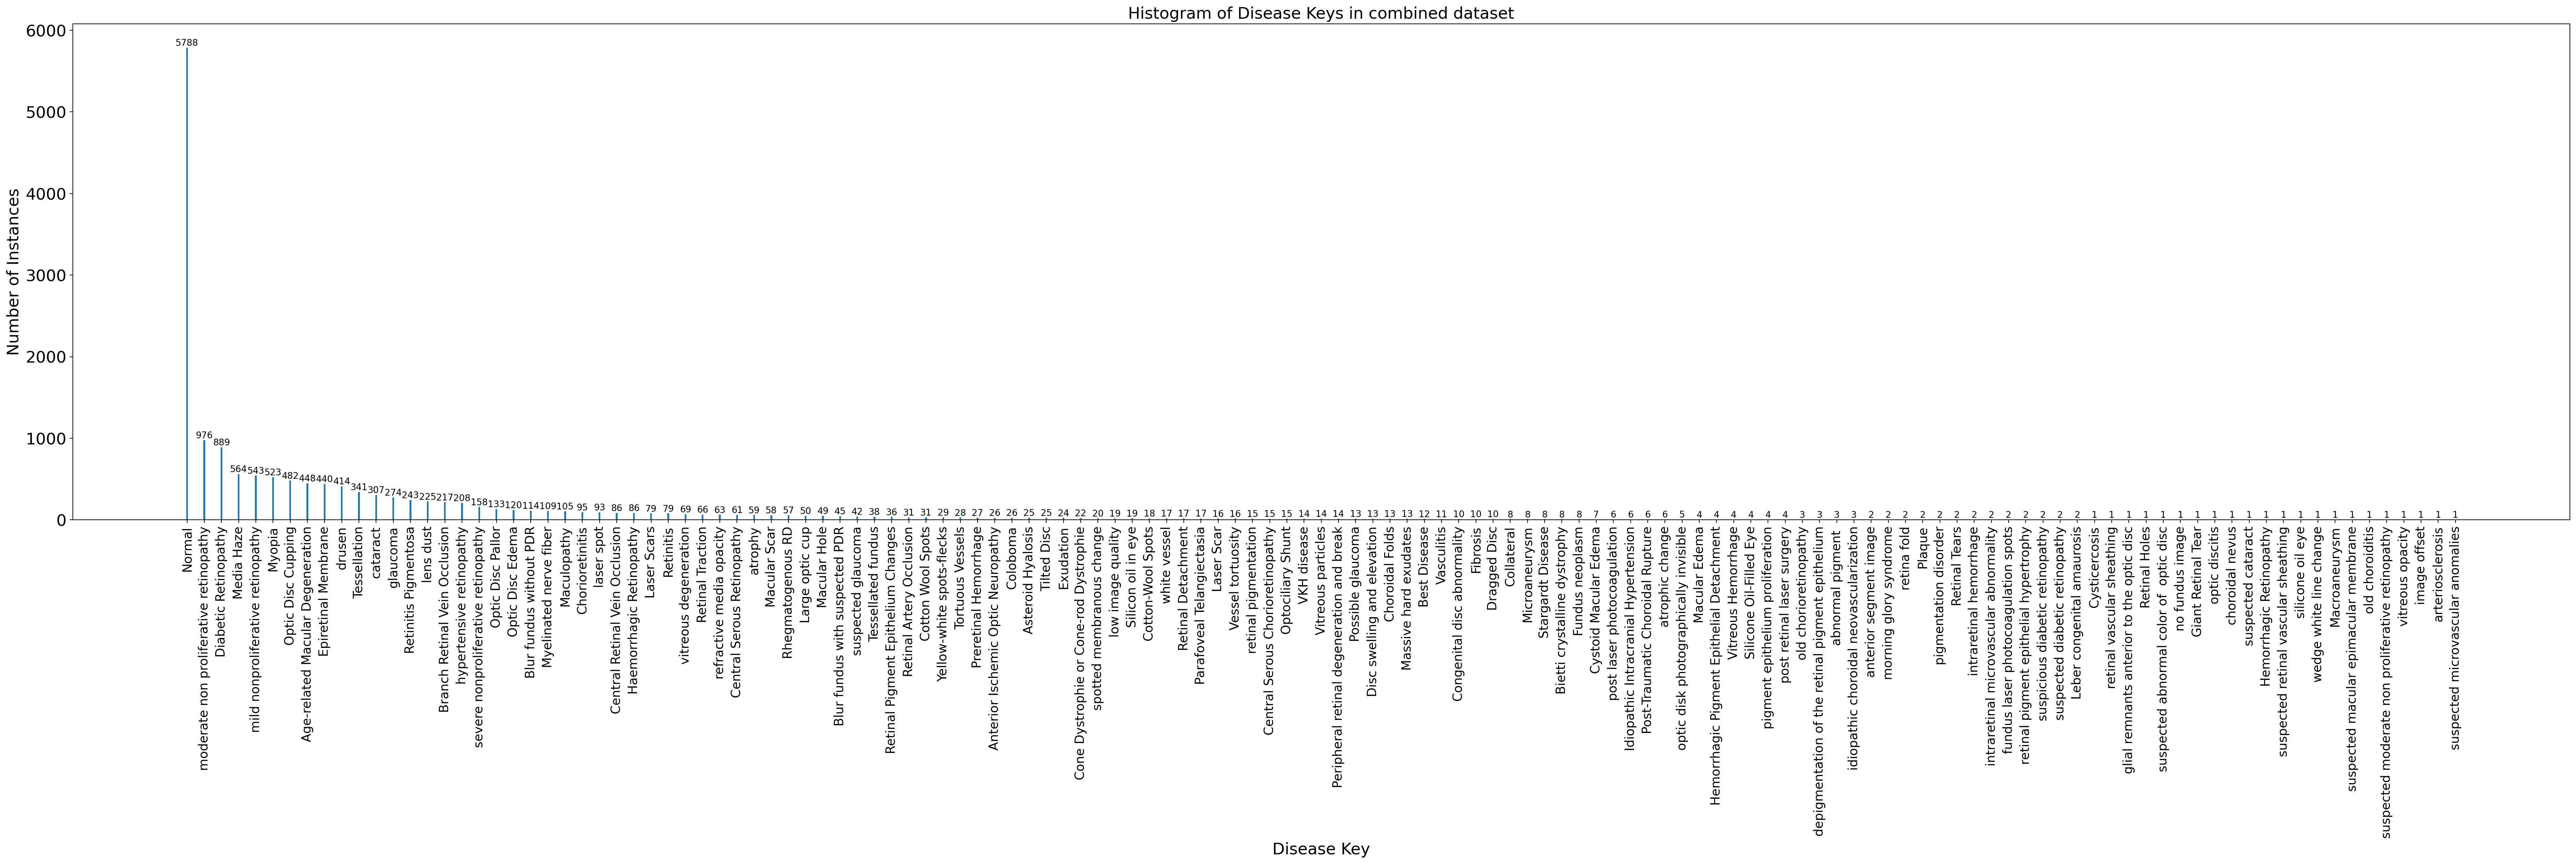

In [18]:
#historgam of the disease keys
# Count the number of instances for each class
counts = all_images_df['disease_key'].value_counts()

# Create a bar plot
plt.figure(figsize=(50, 10), dpi=200)
bars = plt.bar(counts.index, counts.values, width=0.1)
# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=10)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=18)
plt.xlabel('Disease Key', fontsize=18)
plt.ylabel('Number of Instances', fontsize=18)
plt.title('Histogram of Disease Keys in combined dataset', fontsize=18)
plt.show()

#Step 5: Get only the diseases we are interested in

In [19]:
sim_table = pd.read_excel('similarity_matrices/2023-12-27_15-25-54_disease_key_matrix.xlsx')
#set index to column named Spalte1
sim_table.set_index('Spalte1', inplace=True)
diseases_of_interest = ['Retinitis Pigmentosa']
#only keep the diseases of interest columns and the index
sim_table_interest = sim_table[diseases_of_interest]

In [20]:
def map_diseases(disease_of_interest : str, disease_key : str):
    mapping = sim_table_interest.loc[disease_key, disease_of_interest]
    #che
    if pd.isna(mapping):
        return disease_key
    if 'sa' in mapping:
        return disease_of_interest
    else:
        return disease_key

In [21]:
#filter all the nan values from the disease table of interest (diseases we are not interested in)
for interesting_disease in diseases_of_interest:
    sim_table_interest = sim_table_interest[sim_table_interest[interesting_disease].notna()]
sim_table_interest

Retinitis Pigmentosa
Spalte1                                                                                  
Age-related Macular Degeneration                            si for a non expert in retina
Best Disease                                                si for a non expert in retina
Bietti crystalline dystrophy                                si for a non expert in retina
cataract                                ns, but worth training the algorithm to detect...
Cone Dystrophie or Cone-rod Dystrophie                      si for a non expert in retina
Diabetic Retinopathy                    ns, but worth training the algorithm to detect...
glaucoma                                ns, but worth training the algorithm to detect...
Leber congenital amaurosis                                  si for a non expert in retina
Maculopathy                                                 si for a non expert in retina
Myopia                                  ns, but worth training the algorithm to detect...
Normal                                                                                 ns
Retinitis Pigmentosa                                                                   sa
Stargardt Disease                                           si for a non expert in retina

In [22]:
#create a dataframe which only contains the diseases which are in the index column of the sim_table_interest
disease_keys = list(sim_table_interest.index)
#filter all_images_df by the disease keys
all_images_df_interest = all_images_df[all_images_df['disease_key'].isin(disease_keys)]

In [23]:
#generated a filtered diseas key map which only contains the diseases of interest as keys
disease_key_map_filtered = {}
for key in disease_key_map.keys():
    value = disease_key_map[key]
    if value in disease_keys:
        disease_key_map_filtered[key] = disease_key_map[key]
disease_key_map_filtered

{'myopia retinopathy': 'Myopia',
 'Pathological myopia': 'Myopia',
 'pathological myopia': 'Myopia',
 'Retinitis pigmentosa': 'Retinitis Pigmentosa',
 'retinitis pigmentosa': 'Retinitis Pigmentosa',
 'maculopathy': 'Maculopathy',
 'myopic maculopathy': 'Maculopathy',
 'Optic Disc Pit Maculopathy': 'Maculopathy',
 'diabetic retinopathy': 'Diabetic Retinopathy',
 'proliferative diabetic retinopathy': 'Diabetic Retinopathy',
 'severe proliferative diabetic retinopathy': 'Diabetic Retinopathy',
 'age-related macular degeneration': 'Age-related Macular Degeneration',
 'dry age-related macular degeneration': 'Age-related Macular Degeneration',
 'wet age-related macular degeneration': 'Age-related Macular Degeneration'}

Step 6: drop diseases with less than 3 entries

In [24]:
#drop entries with disease keys which have less than x images
min_count = 3
all_images_df_interest = all_images_df_interest.groupby('disease_key').filter(lambda x: len(x) >= min_count)

Step 7: combine duplicate entries (duplicates exist because each image with several disease keys has one entrie for every disease key)

In [25]:
#find duplicate path_to_img and join the disease keys with a comma to a single row
all_images_df_interest_joined_disease_keys = all_images_df_interest.groupby('path_to_img')['disease_key'].apply(', '.join).reset_index()
#drop duplicates
all_images_df_interest_joined_disease_keys.drop_duplicates(subset=['path_to_img'], keep='first', inplace=True)
#show cases with multi disease keys
all_images_df_interest_joined_disease_keys[all_images_df_interest_joined_disease_keys['disease_key'].str.contains(',')].head(10)
#check if there are duplicates
all_images_df_interest_joined_disease_keys[all_images_df_interest_joined_disease_keys.duplicated(subset=['path_to_img'])]


Empty DataFrame
Columns: [path_to_img, disease_key]
Index: []

Step 8: Generate a column for each existing disease key to enable one hot encoding

In [26]:
#get a set of all the disease keys
all_disease_key_set = set()
for disease_key in all_images_df_interest_joined_disease_keys['disease_key']:
    disease_key_splitted = disease_key.split(', ')
    all_disease_key_set.update(disease_key_splitted)

#generate a new column for each disease key which is 1 if the disease key is in the disease key column and 0 otherwise
for disease_key in all_disease_key_set:
    all_images_df_interest_joined_disease_keys[disease_key] = all_images_df_interest_joined_disease_keys['disease_key'].str.contains(disease_key).astype(int)

Step 9: Balance the Dataframe

In [27]:
#random drop to balance the dataset
def get_droppable_entries(df : pd.DataFrame, label_names : list, median_deviation : float):
    #get label counts
    label_counts = df[label_names].sum(axis=0)
    #get median
    label_counts_median = label_counts.median()
    max_number_of_images = label_counts_median * (1 + median_deviation)
    #cehck which labels have more than the median
    #get labels which should be kept
    labels_to_keep = label_counts[label_counts <= max_number_of_images].index
    #filter the df by the labels to keep by summing the labels and checking if the sum is greater than 0
    possible_drops_df = df.apply(lambda x: x[labels_to_keep].sum() == 0, axis=1)
    n_images_to_drop = label_counts - max_number_of_images
    return possible_drops_df, n_images_to_drop

def drop_n_images_by_key(df_to_drop_from : pd.DataFrame, df_droppable_entries : pd.DataFrame, n_images_to_drop : int, label_name : str):
    #get all the entries which have the label
    df_with_label = df_to_drop_from[df_to_drop_from[label_name] == 1]
    #get the indices of the images to drop
    indices_to_drop = df_with_label.sample(n=n_images_to_drop).index
    #drop the images
    df_dropped_images = df_to_drop_from.drop(indices_to_drop, inplace=False)
    return df_dropped_images

In [28]:
#create list with label names
label_names = list(all_disease_key_set)

#get all labels
labels = all_images_df_interest_joined_disease_keys[label_names].values
print(labels.shape, 'number of dieases: ', len(label_names))

(7597, 12) number of dieases:  12


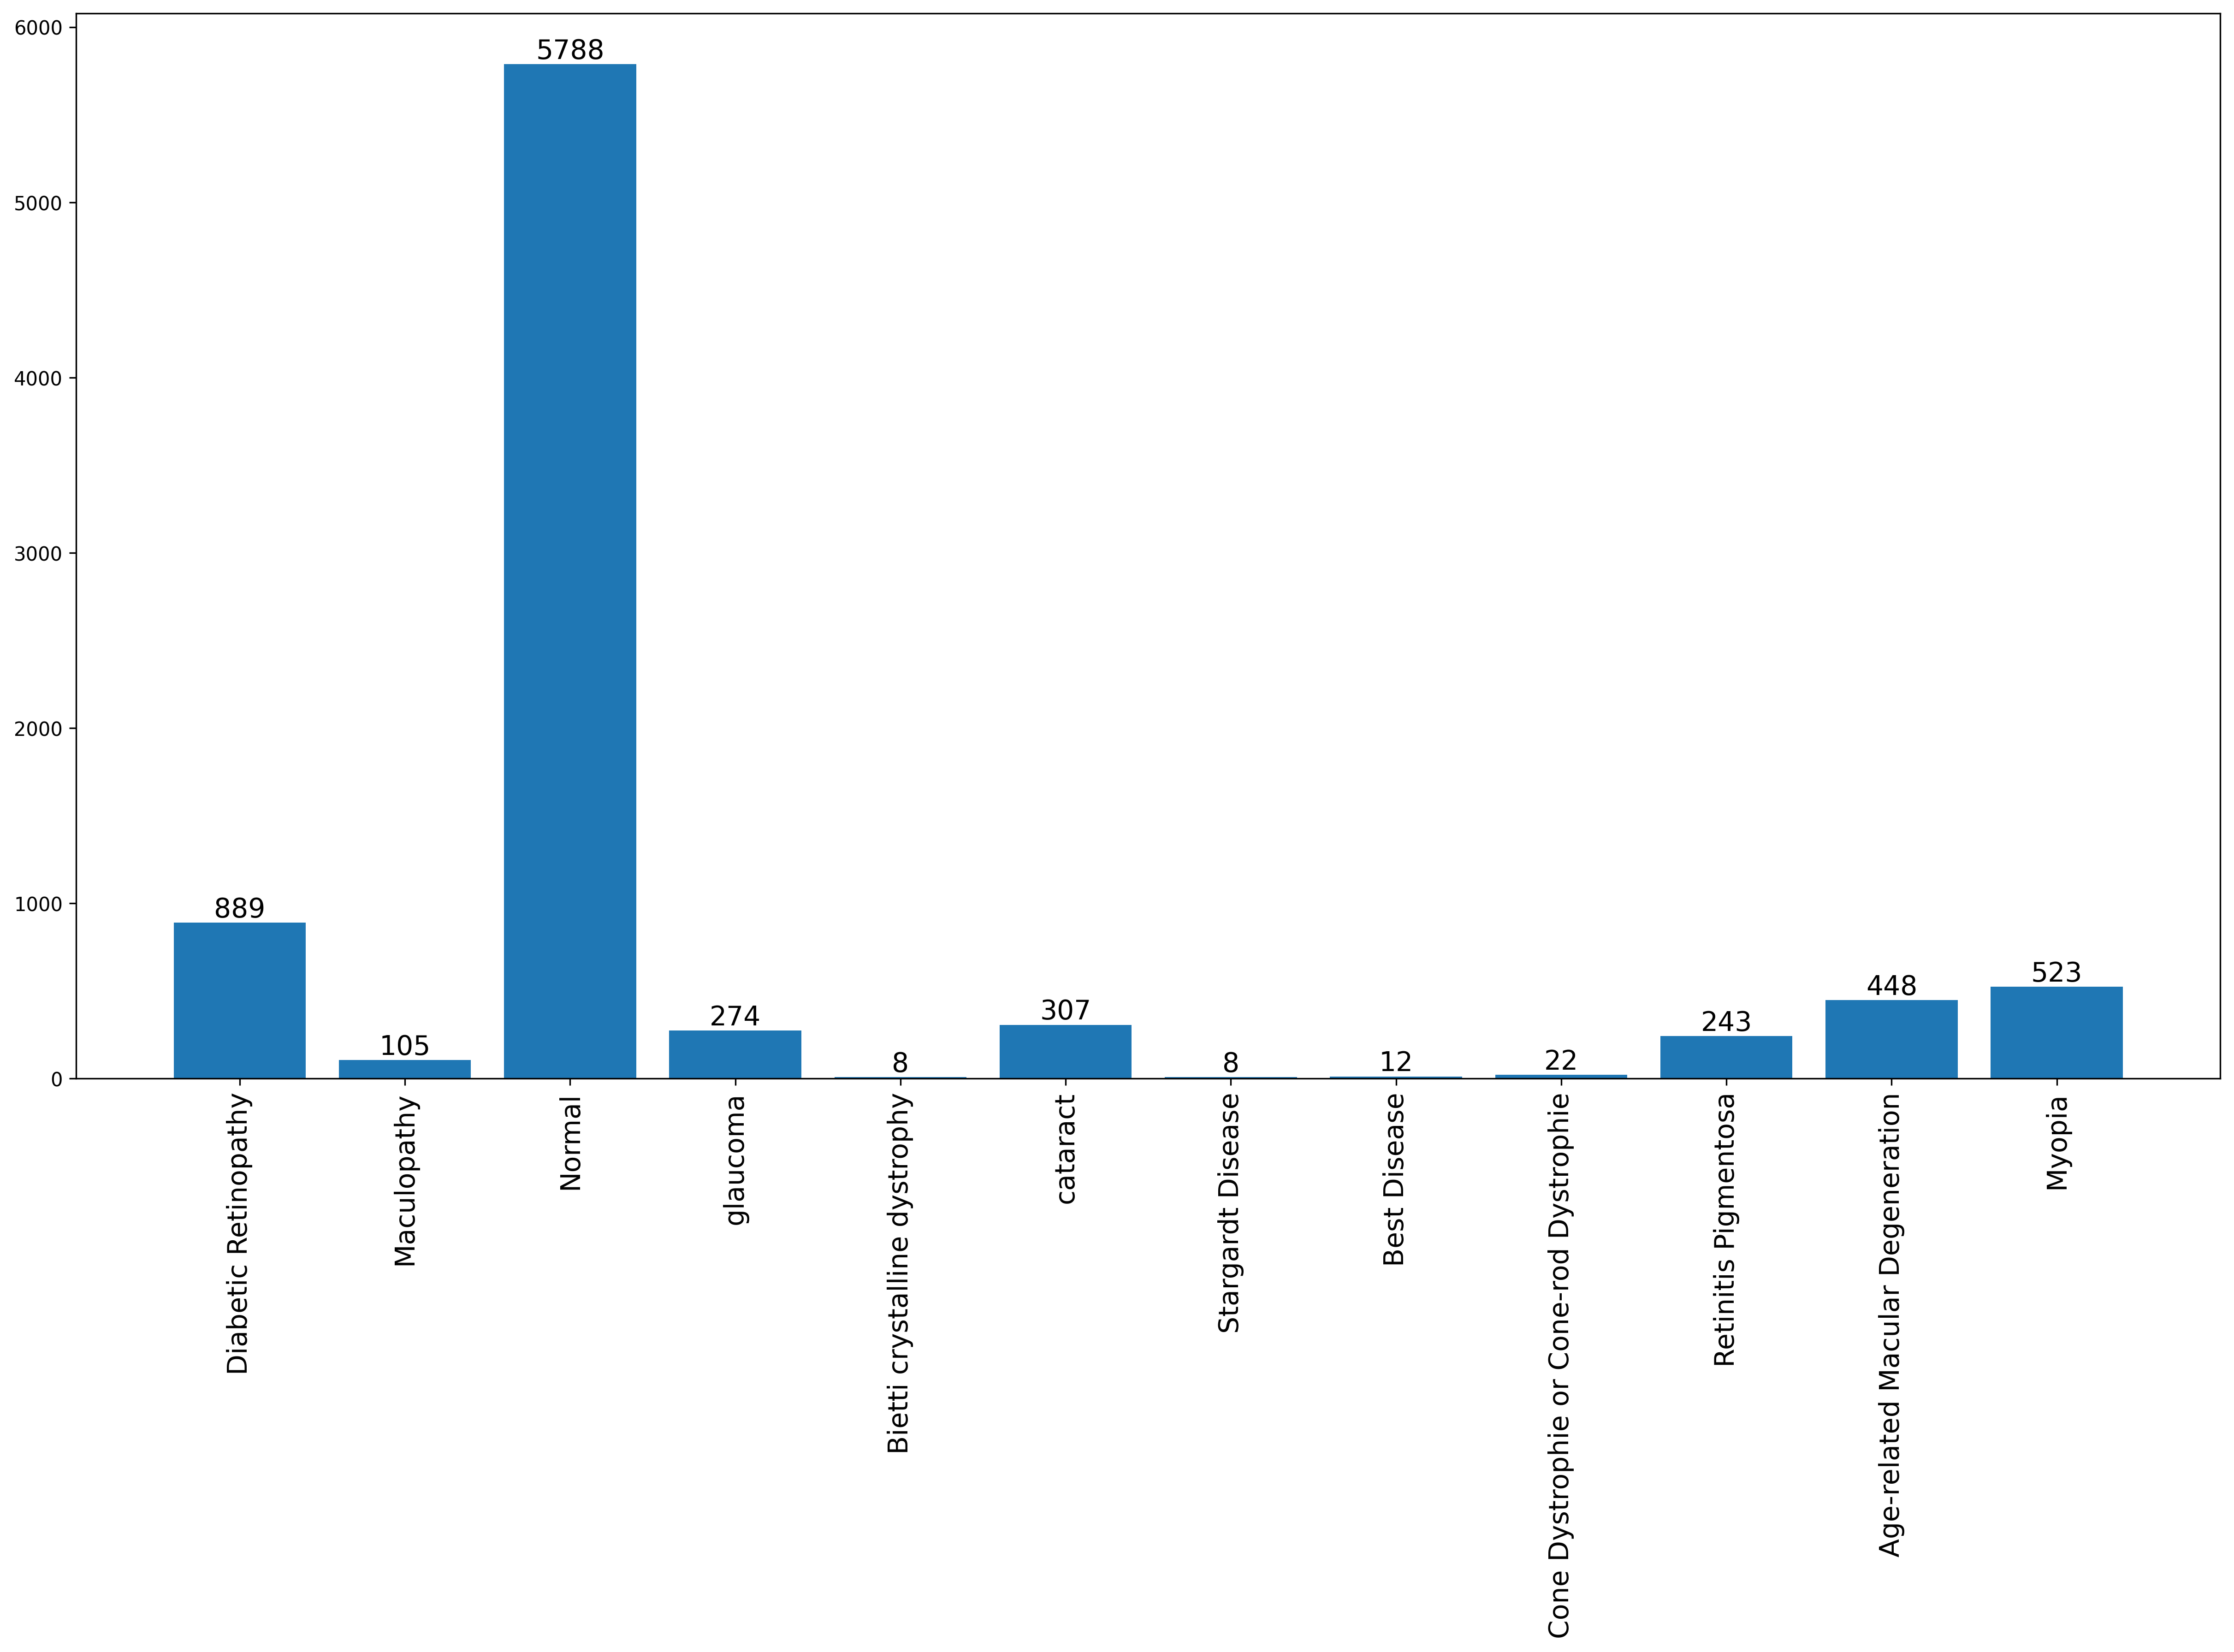

In [29]:
#plot the histogram of the disease keys
# Count the number of instances for each class
counts = all_images_df_interest_joined_disease_keys[label_names].sum(axis=0)
#plot the histogram
plt.figure(figsize=(20, 10), dpi=300)
bars = plt.bar(counts.index, counts.values)
plt.xticks(fontsize=14, rotation=90)
# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=14)

In [30]:
balanced_df = all_images_df_interest_joined_disease_keys
for disease_key in label_names:
    #get the df with the droppable entries
    df_droppable_entries, n_images_to_drop = get_droppable_entries(balanced_df, label_names, 0.3)
    if n_images_to_drop[disease_key] > 0:
        #drop the images
        n_images_to_drop_rounded = int(n_images_to_drop[disease_key])
        balanced_df = drop_n_images_by_key(balanced_df, df_droppable_entries, n_images_to_drop_rounded, disease_key)

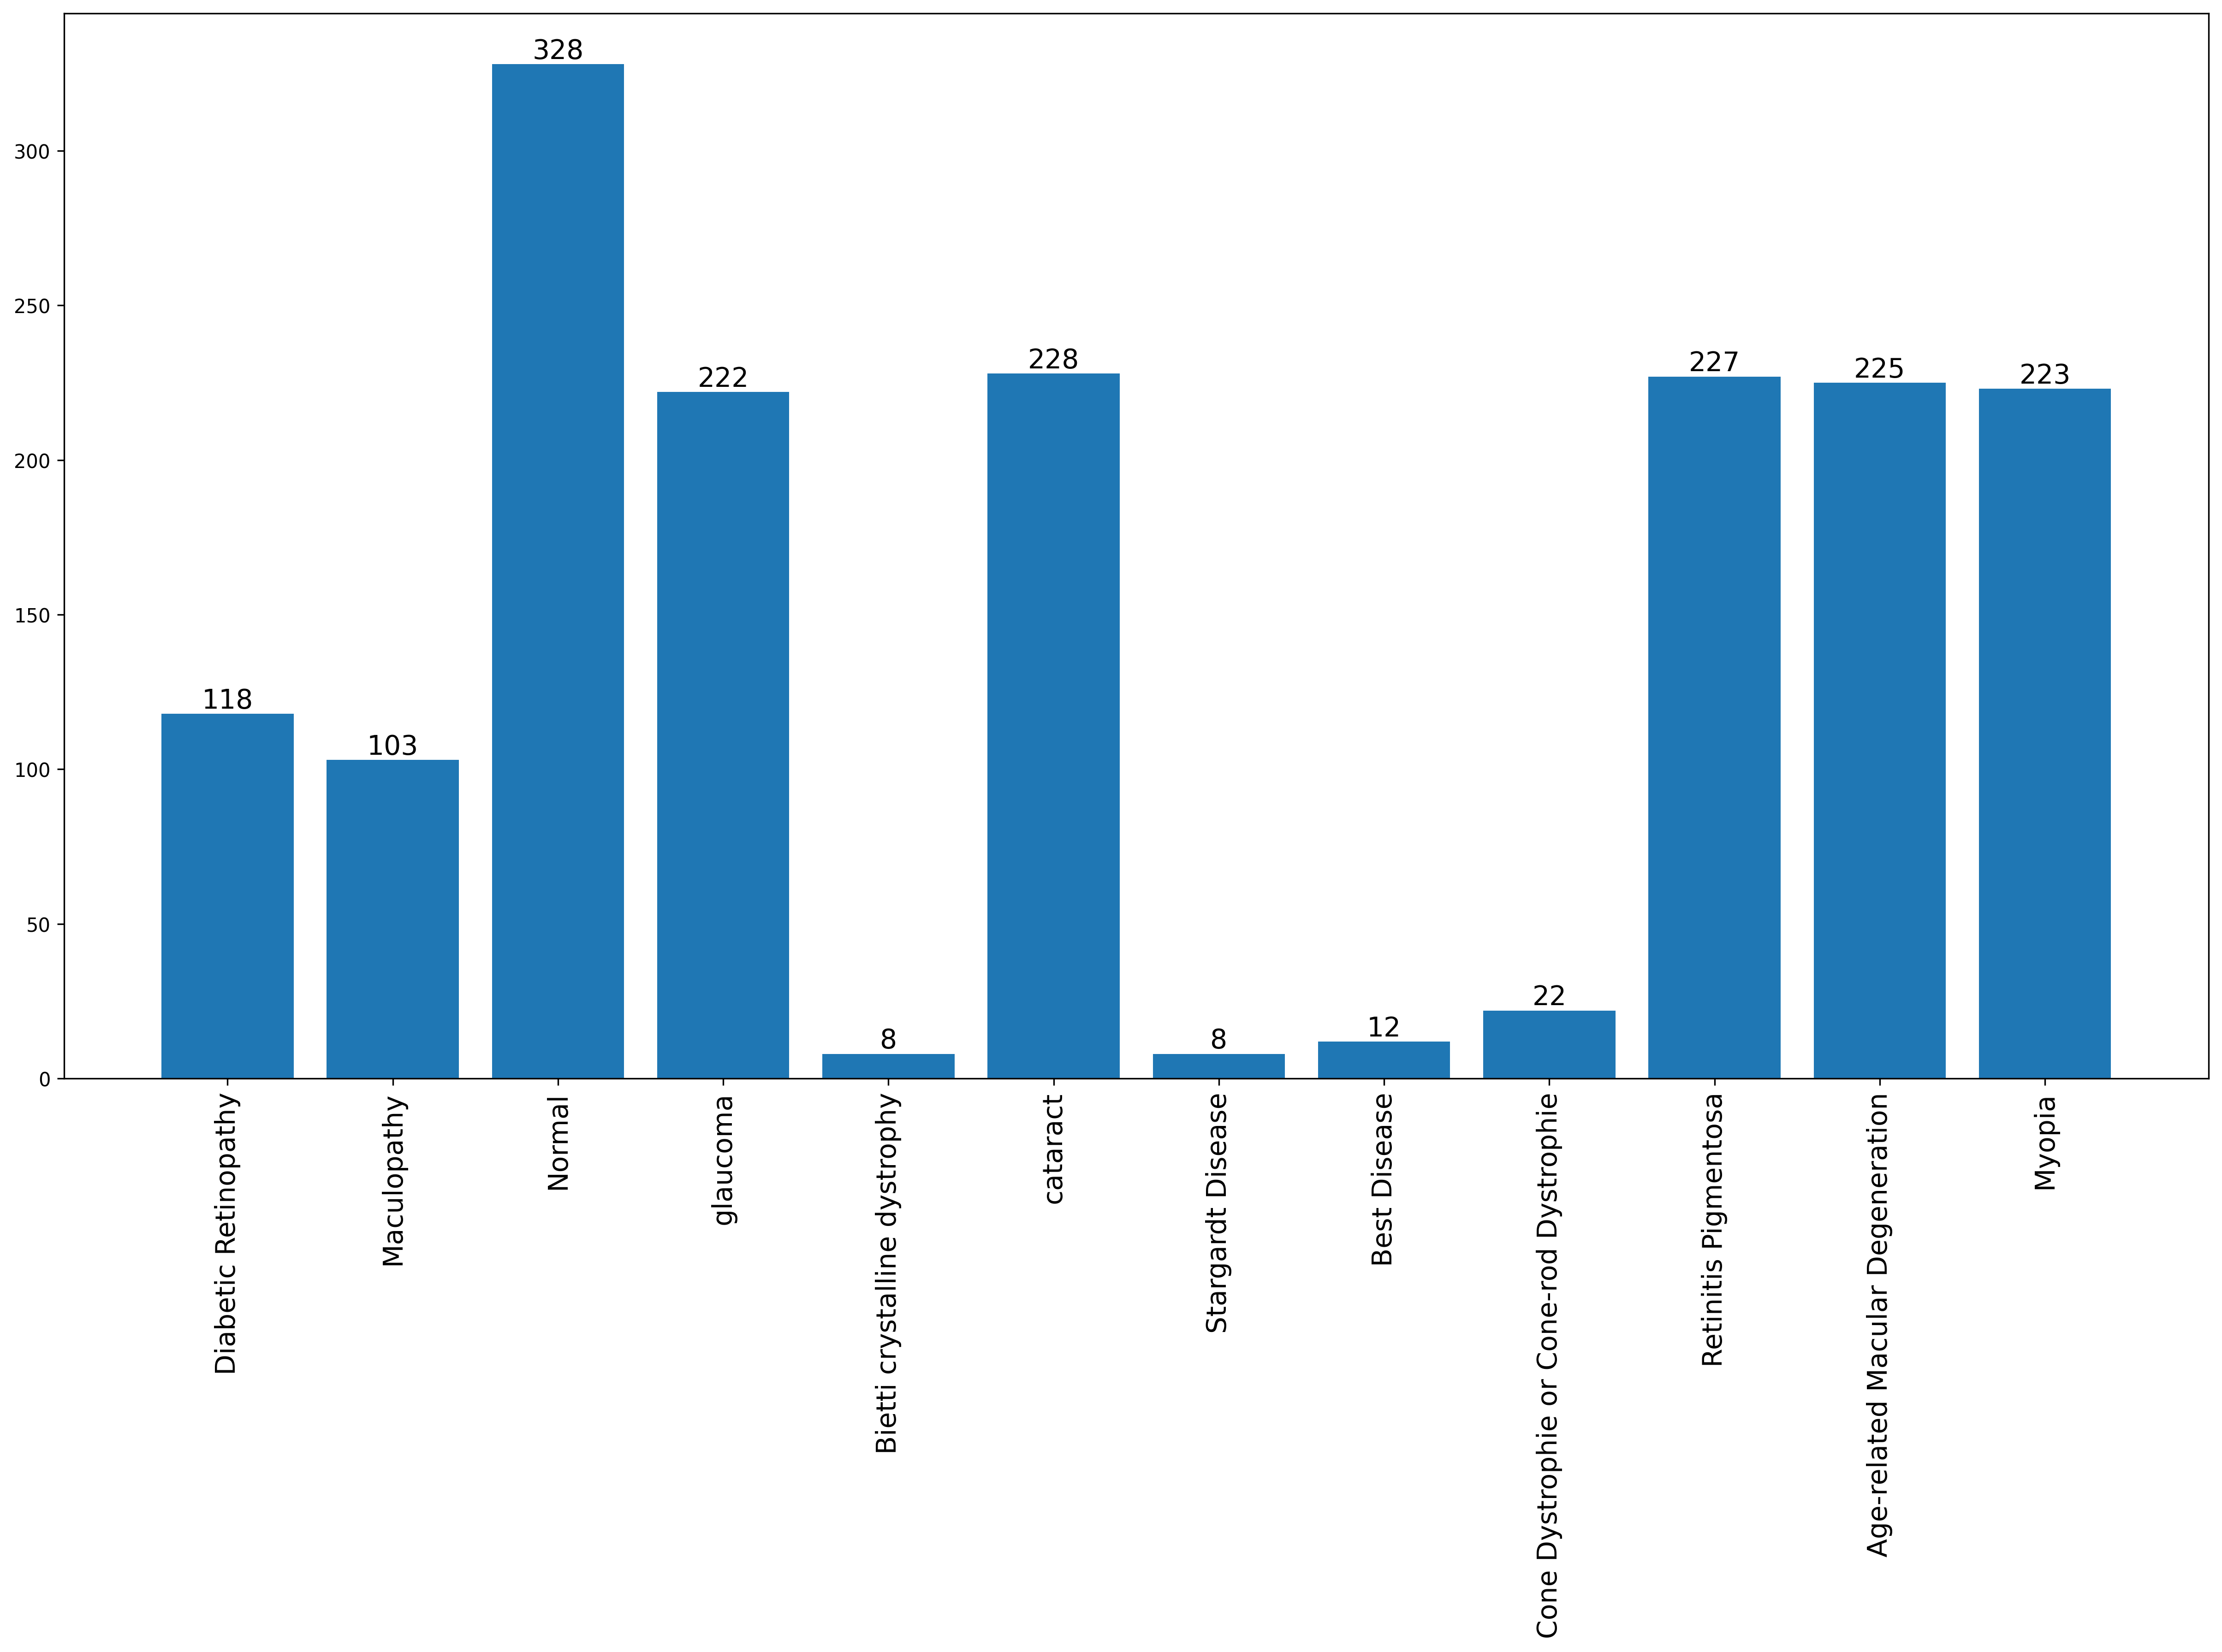

In [31]:
#plot the histogram of the disease keys
# Count the number of instances for each class
counts = balanced_df[label_names].sum(axis=0)
#plot the histogram
plt.figure(figsize=(20, 10), dpi=300)
bars = plt.bar(counts.index, counts.values)
plt.xticks(fontsize=14, rotation=90)
# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=14)

Step 10: stratified split on dataset

In [32]:
def stratified_multilabel_dataset_split(df : pd.DataFrame, train_frac : float, validation_frac : float, test_frac : float, random_state : int = 42):
    labels = df[label_names].values
    #convert dataframe to numpy array
    df_np = df.values
    X_train, y_train, X_val_test, y_val_test = iterative_train_test_split(X = df_np, y = labels, test_size=validation_frac + test_frac)
    X_val, y_val, X_test, y_test = iterative_train_test_split(X = X_val_test, y = y_val_test, test_size=test_frac / (validation_frac + test_frac))
    #return the splits
    return X_train, y_train, X_val, y_val, X_test, y_test

In [33]:
#splt dataframes into one df that contains the images from the ses folder and one df that contains the images from the other datasets
ses_df = balanced_df[balanced_df['path_to_img'].str.contains('SES')]
western_df = balanced_df[~balanced_df['path_to_img'].str.contains('SES')]

In [34]:
#todo split lebanese dataset from the rest and then perform the stratified split on both dataframes
X_train_ses, y_train_ses, X_val_ses, y_val_ses, X_test_ses, y_test_ses = stratified_multilabel_dataset_split(ses_df, 0.7, 0.1, 0.2)
X_train_western, y_train_western, X_val_western, y_val_western, X_test_western, y_test_western = stratified_multilabel_dataset_split(western_df, 0.7, 0.1, 0.2)

#turn x splits into dataframes
X_train_ses, X_val_ses, X_test_ses = pd.DataFrame(X_train_ses, columns=balanced_df.columns), pd.DataFrame(X_val_ses, columns=balanced_df.columns), pd.DataFrame(X_test_ses, columns=balanced_df.columns)
X_train_western, X_val_western, X_test_western = pd.DataFrame(X_train_western, columns=balanced_df.columns), pd.DataFrame(X_val_western, columns=balanced_df.columns), pd.DataFrame(X_test_western, columns=balanced_df.columns)
#concatinate the splits
X_train = pd.concat([X_train_ses, X_train_western])
X_val = pd.concat([X_val_ses, X_val_western])
X_test = pd.concat([X_test_ses, X_test_western])

stratified_dataframes = [[X_train_ses, X_val_ses, X_test_ses], [X_train_western, X_val_western, X_test_western], [X_train, X_val, X_test]]
stratified_dataframes_names = ['SES', 'Western', 'All']
split_names = ['train', 'validation', 'test']

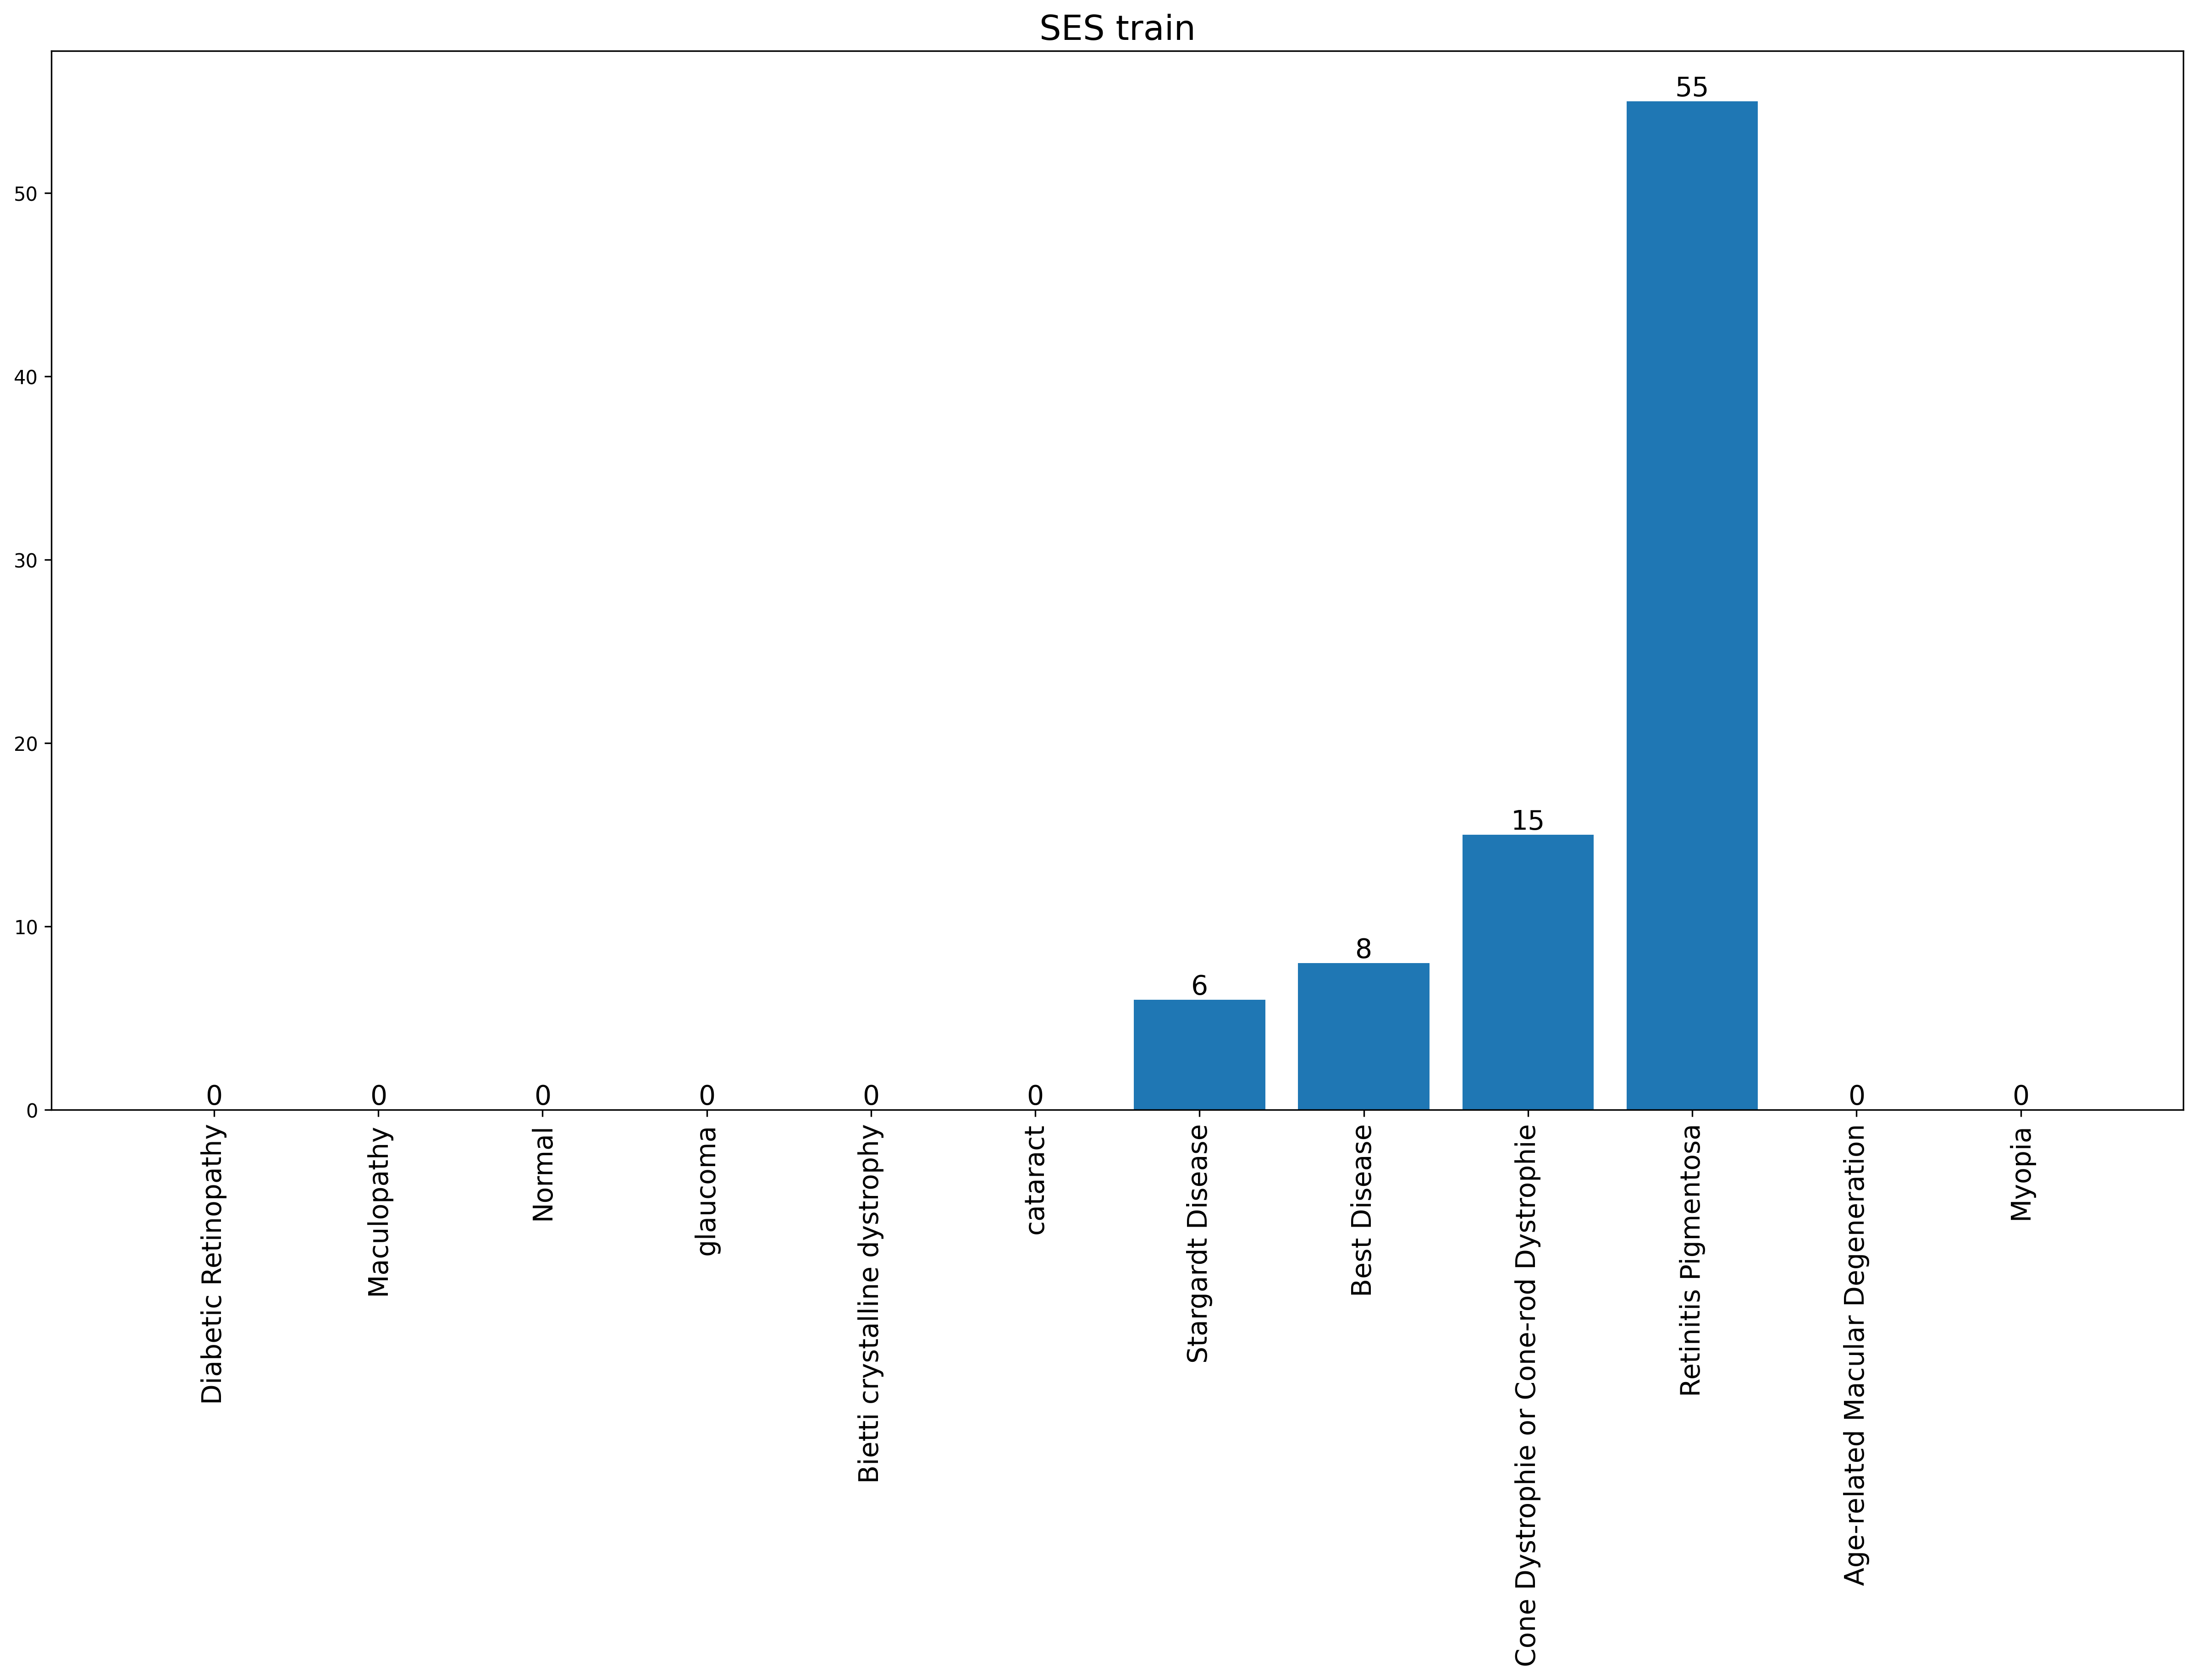

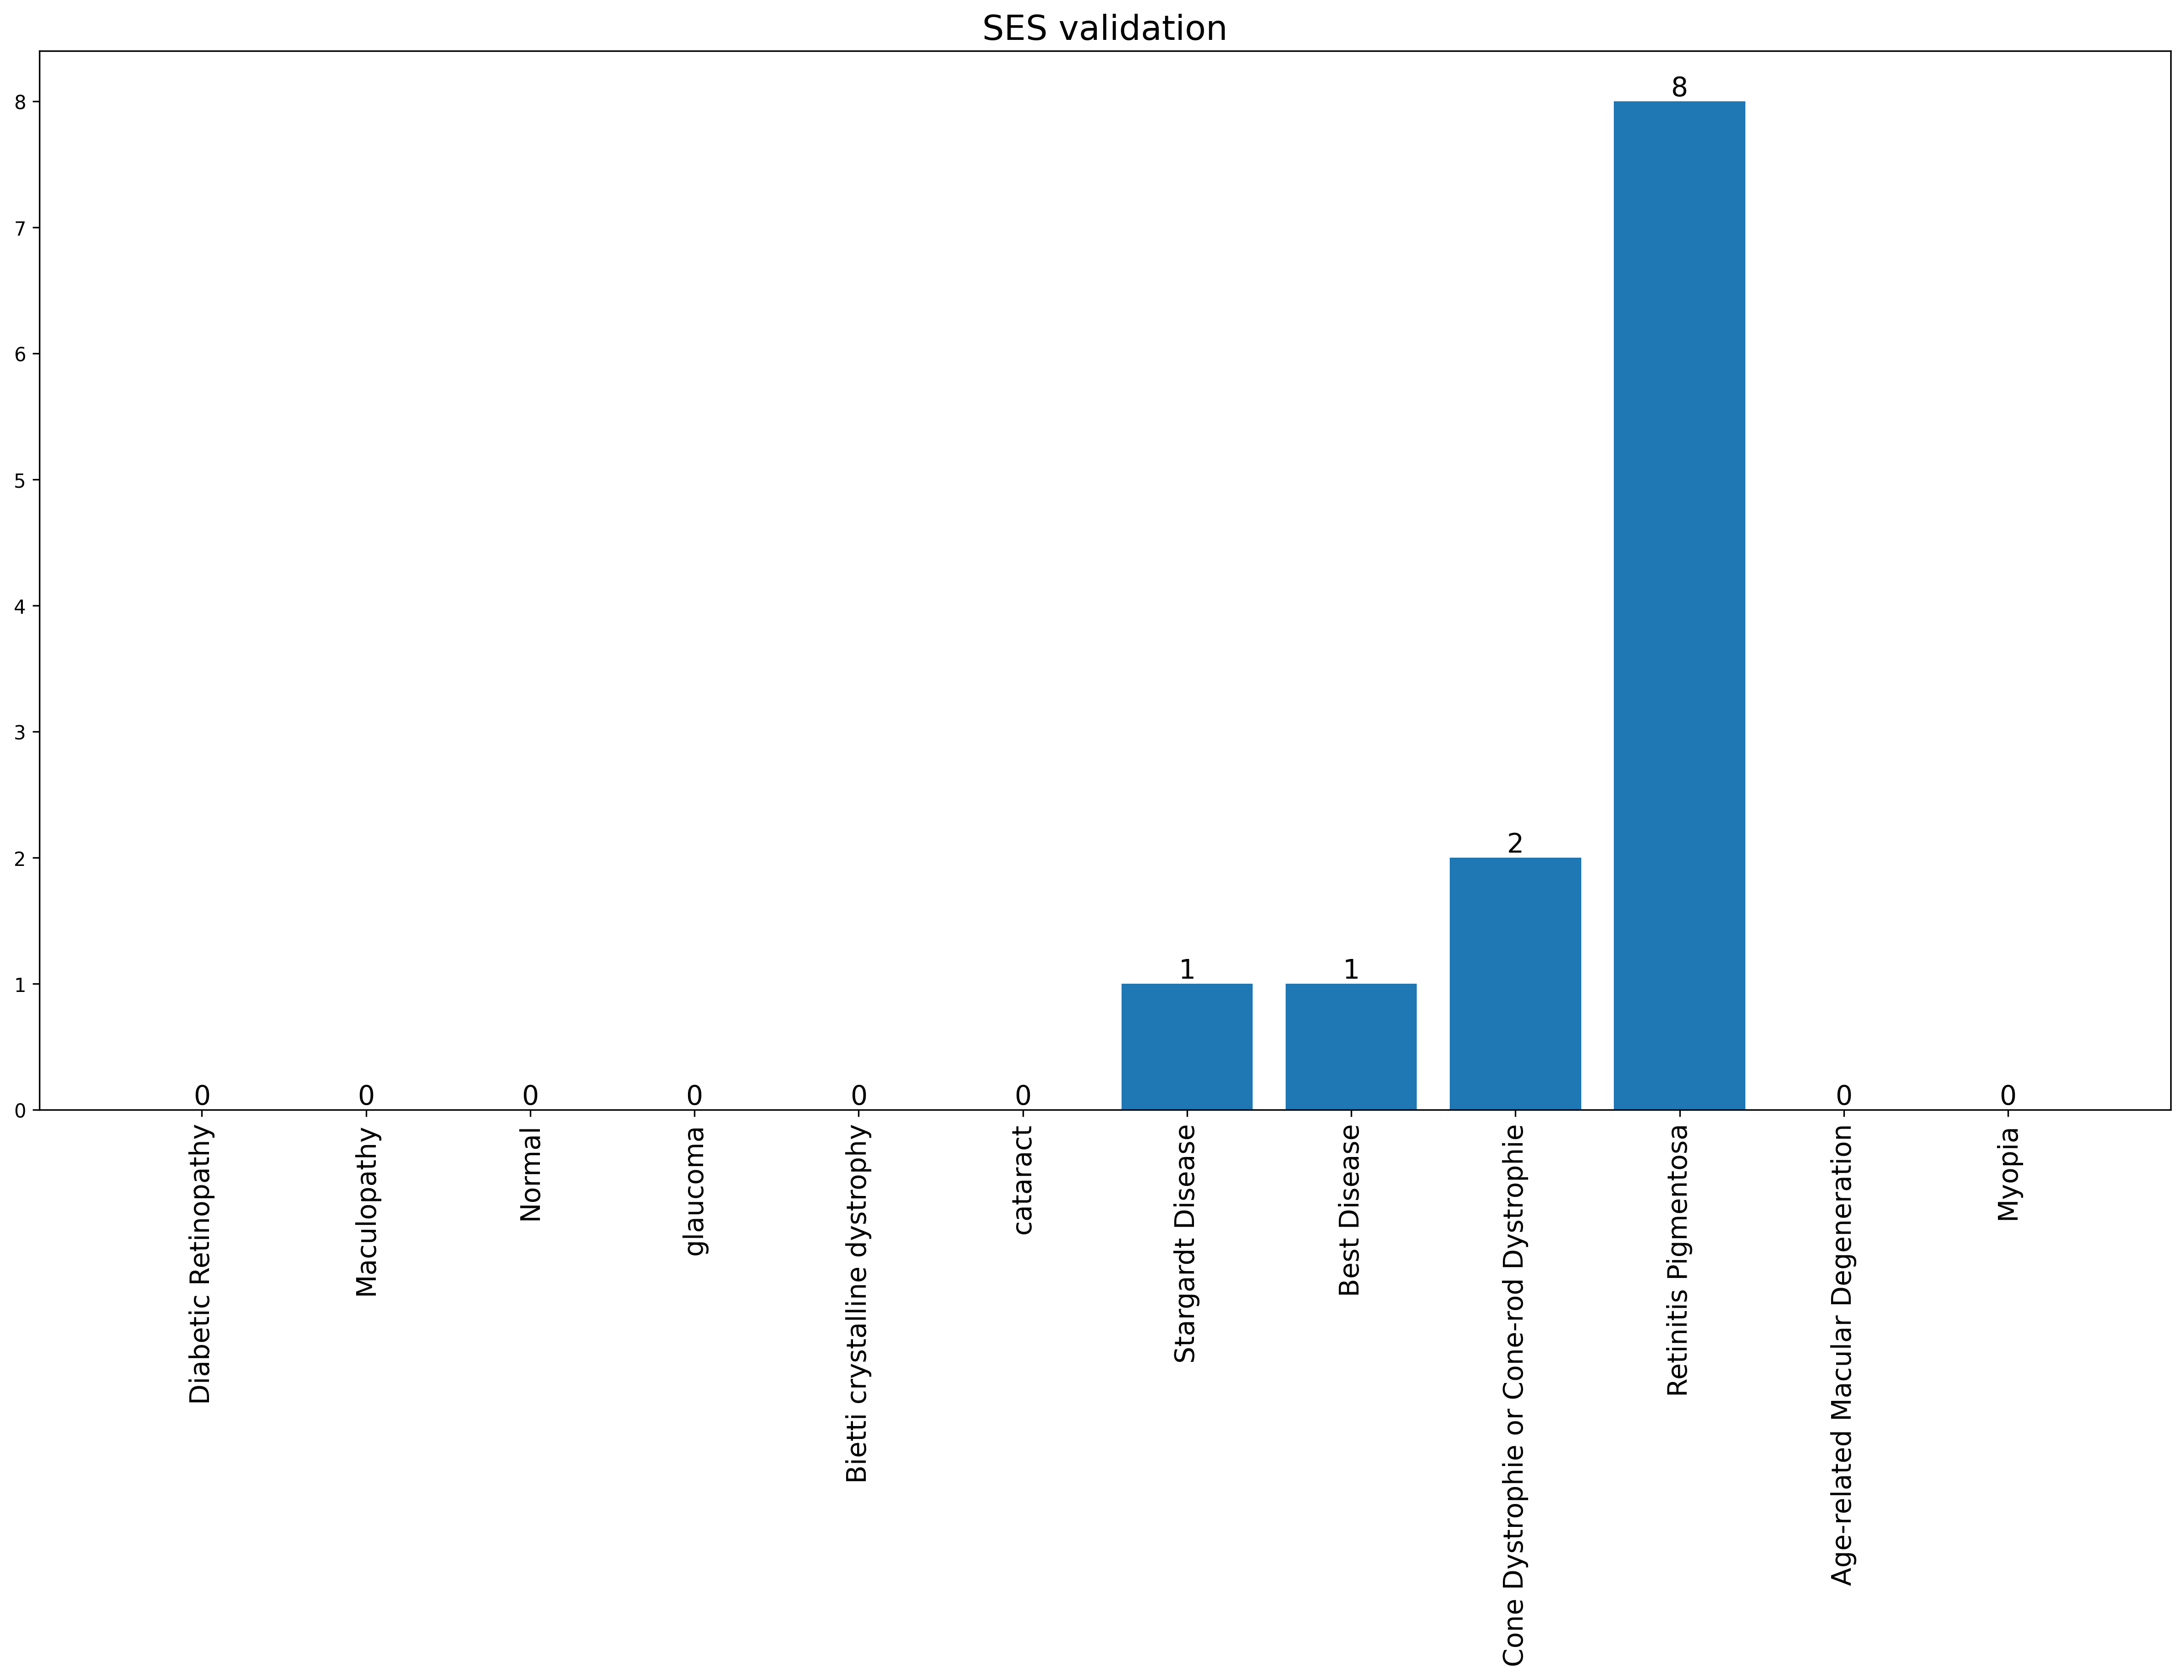

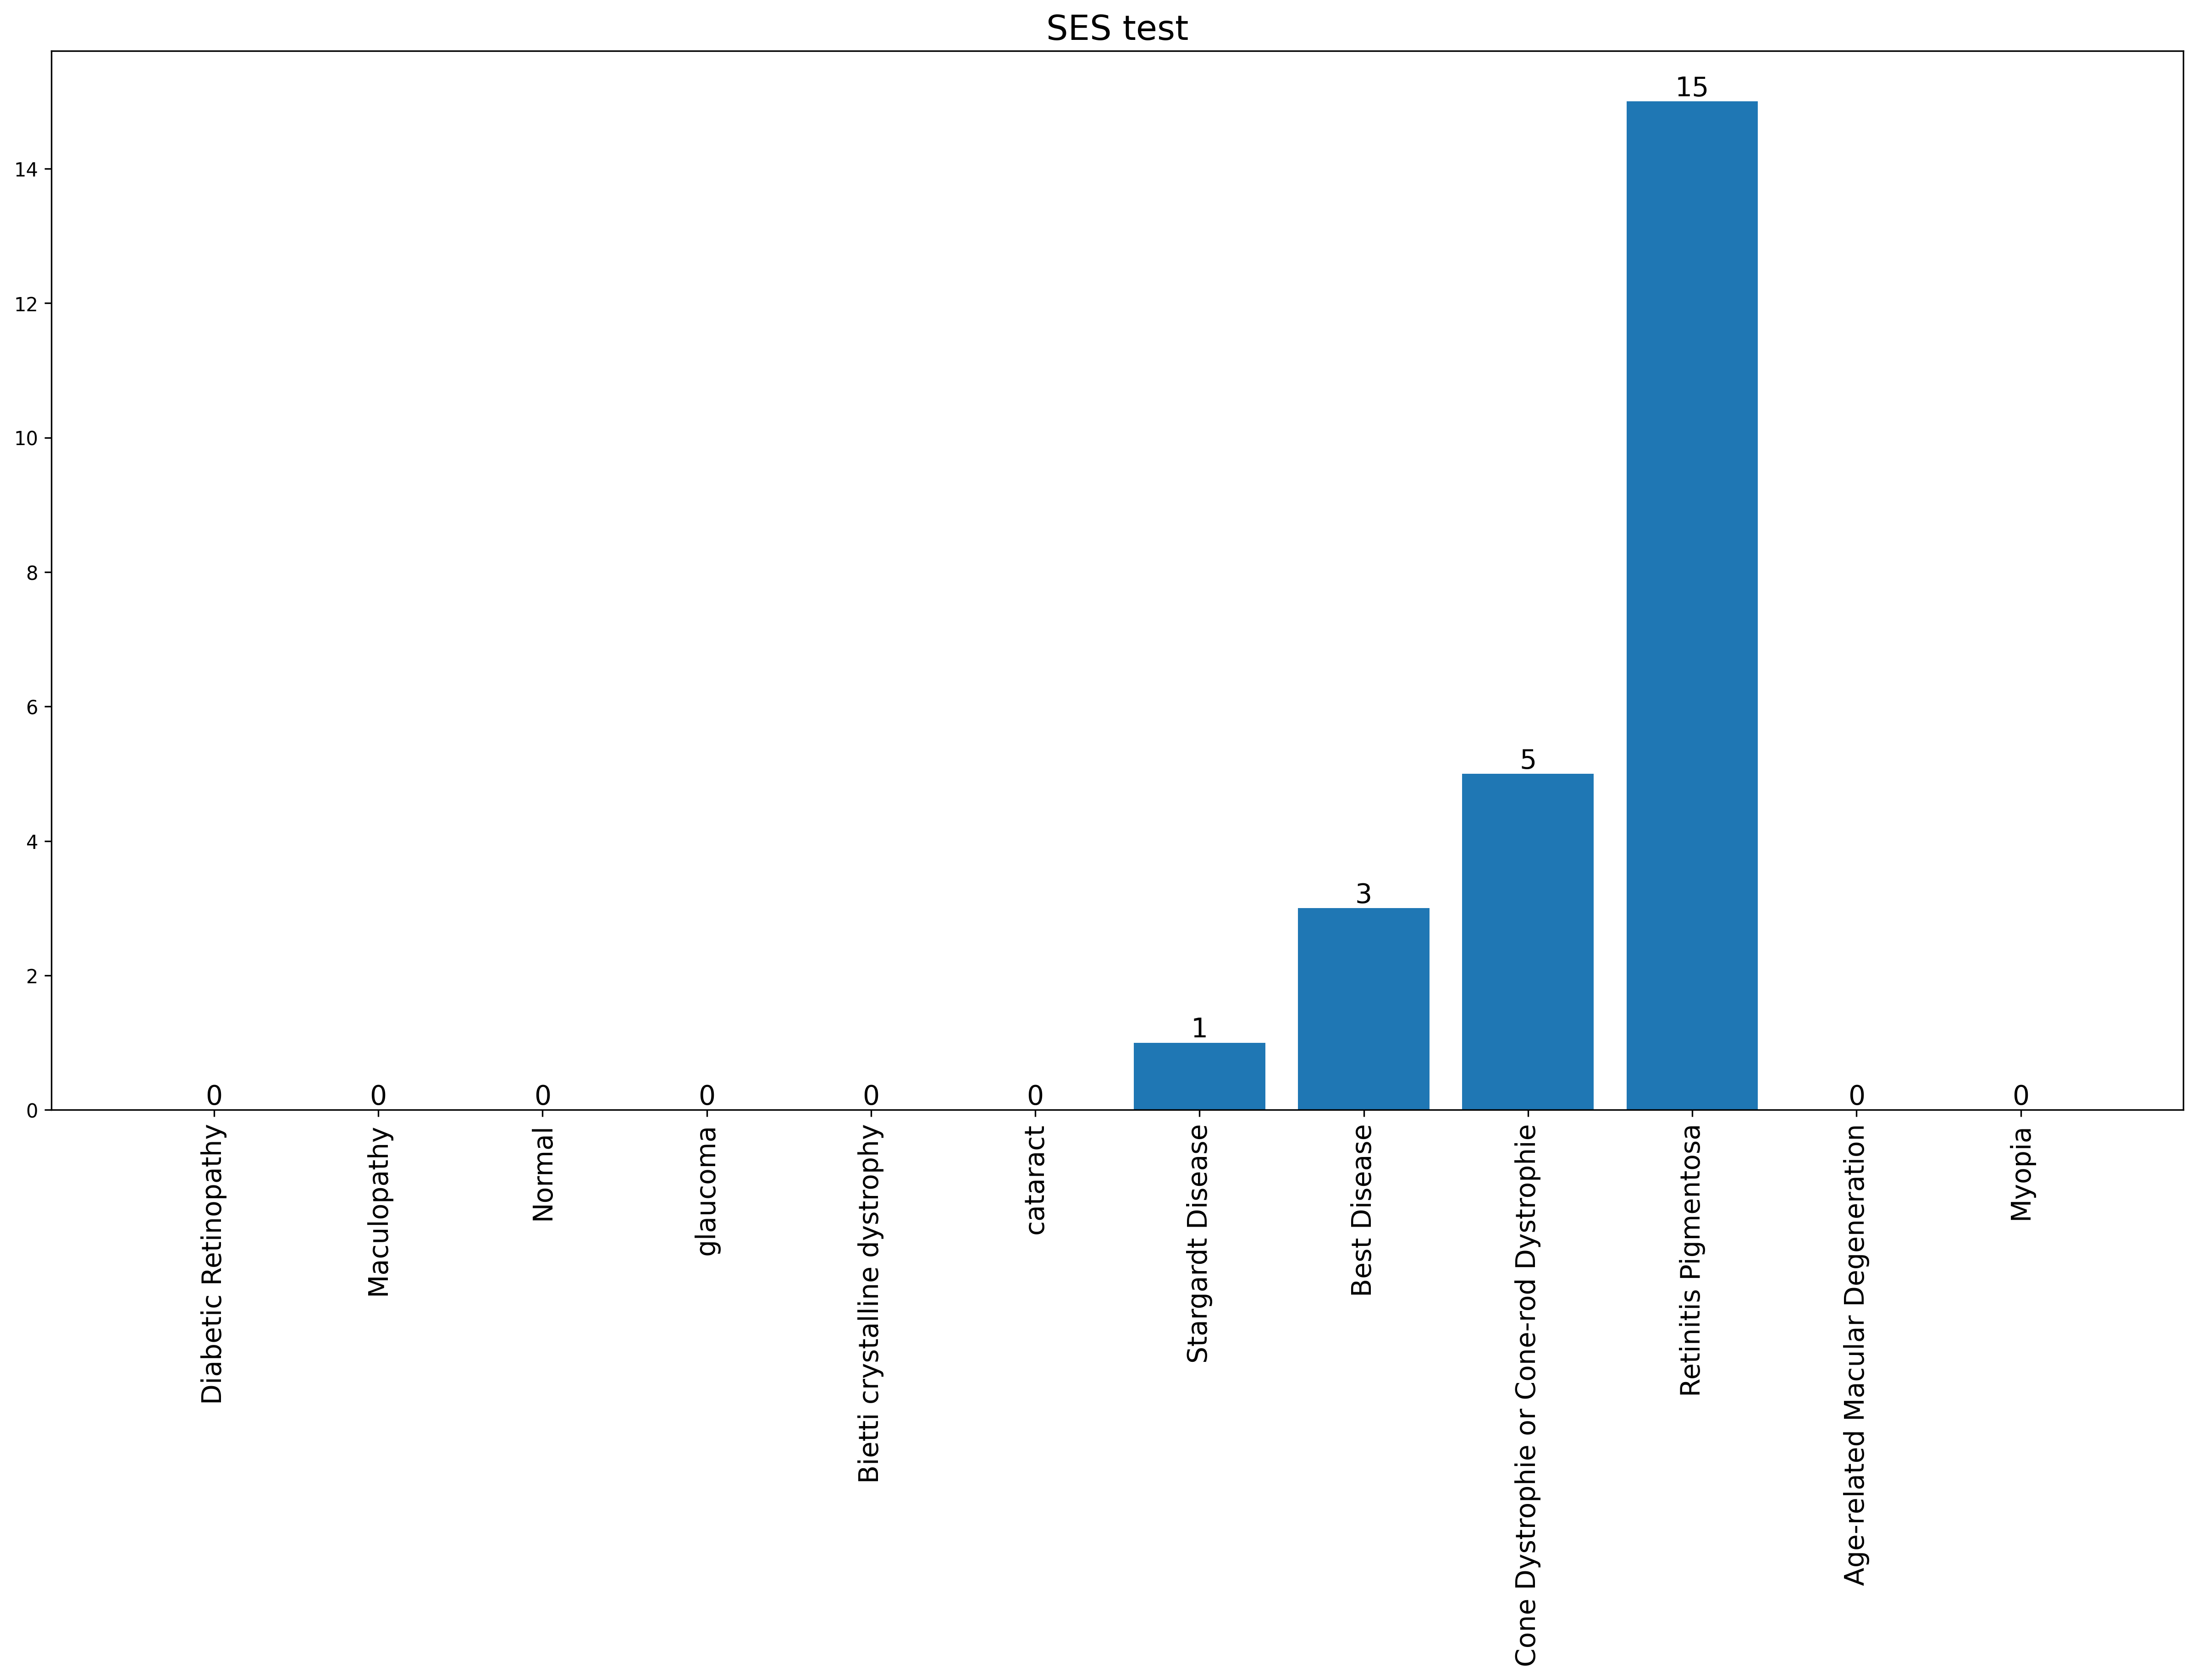

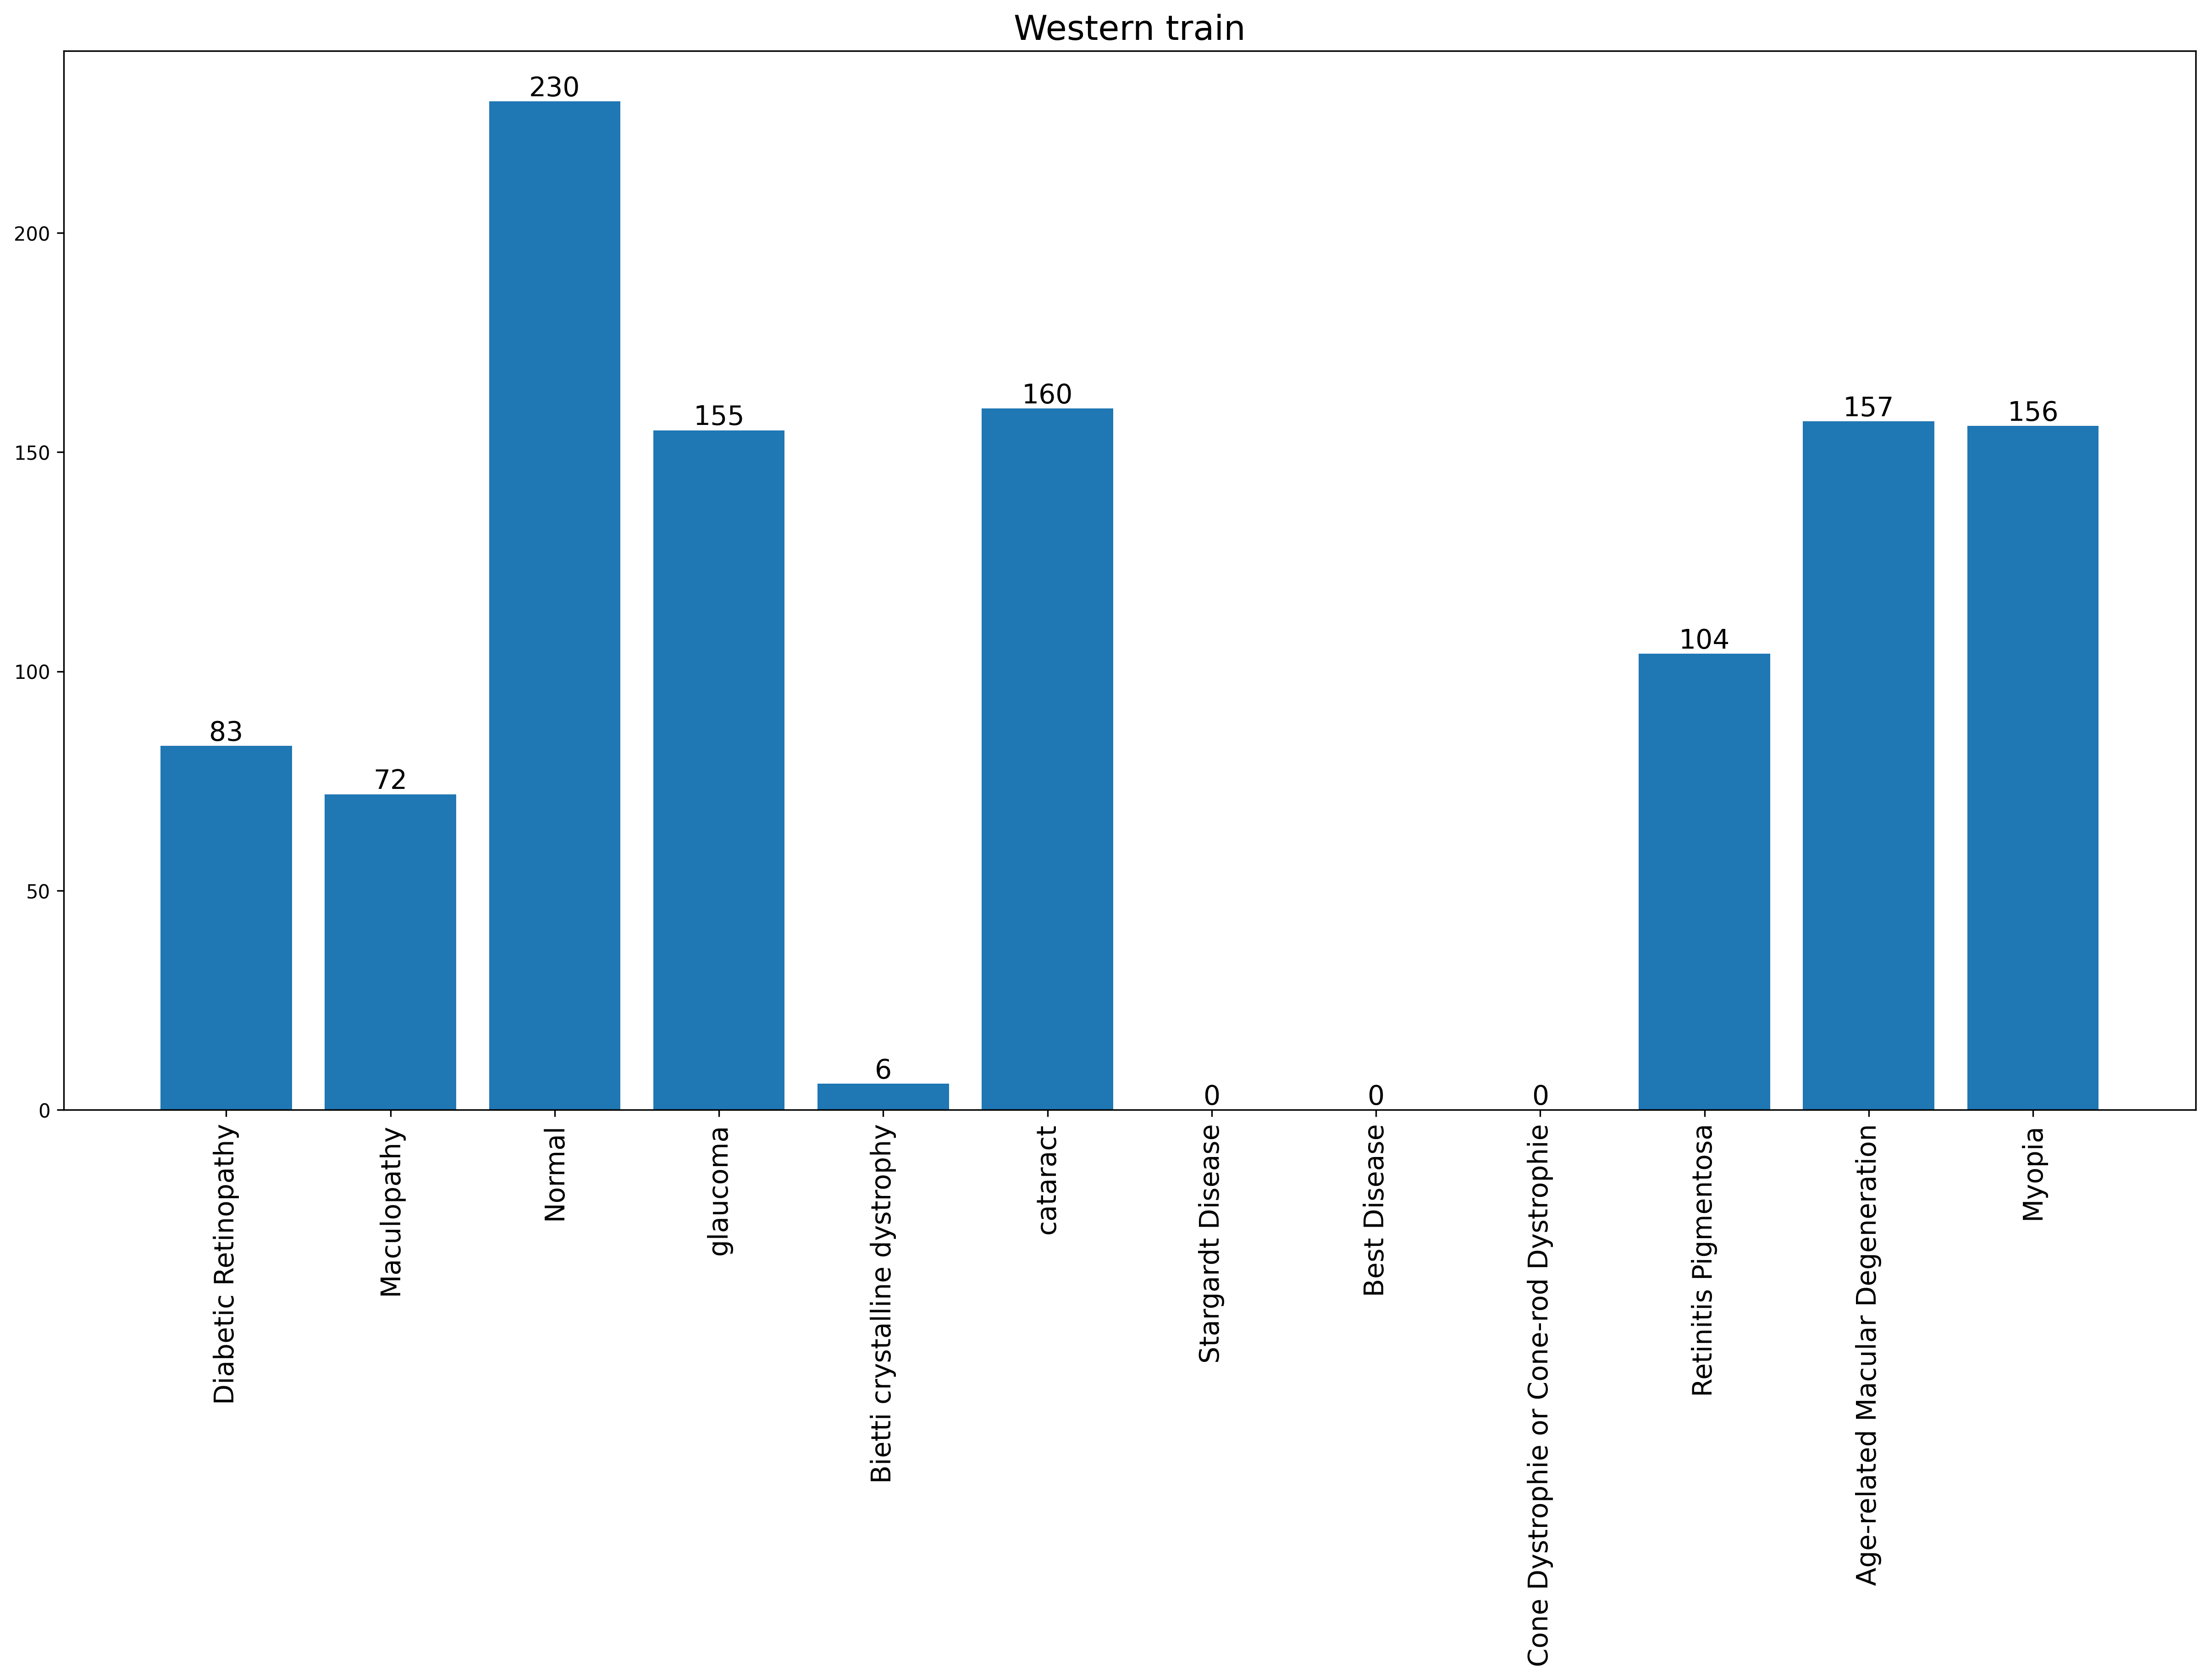

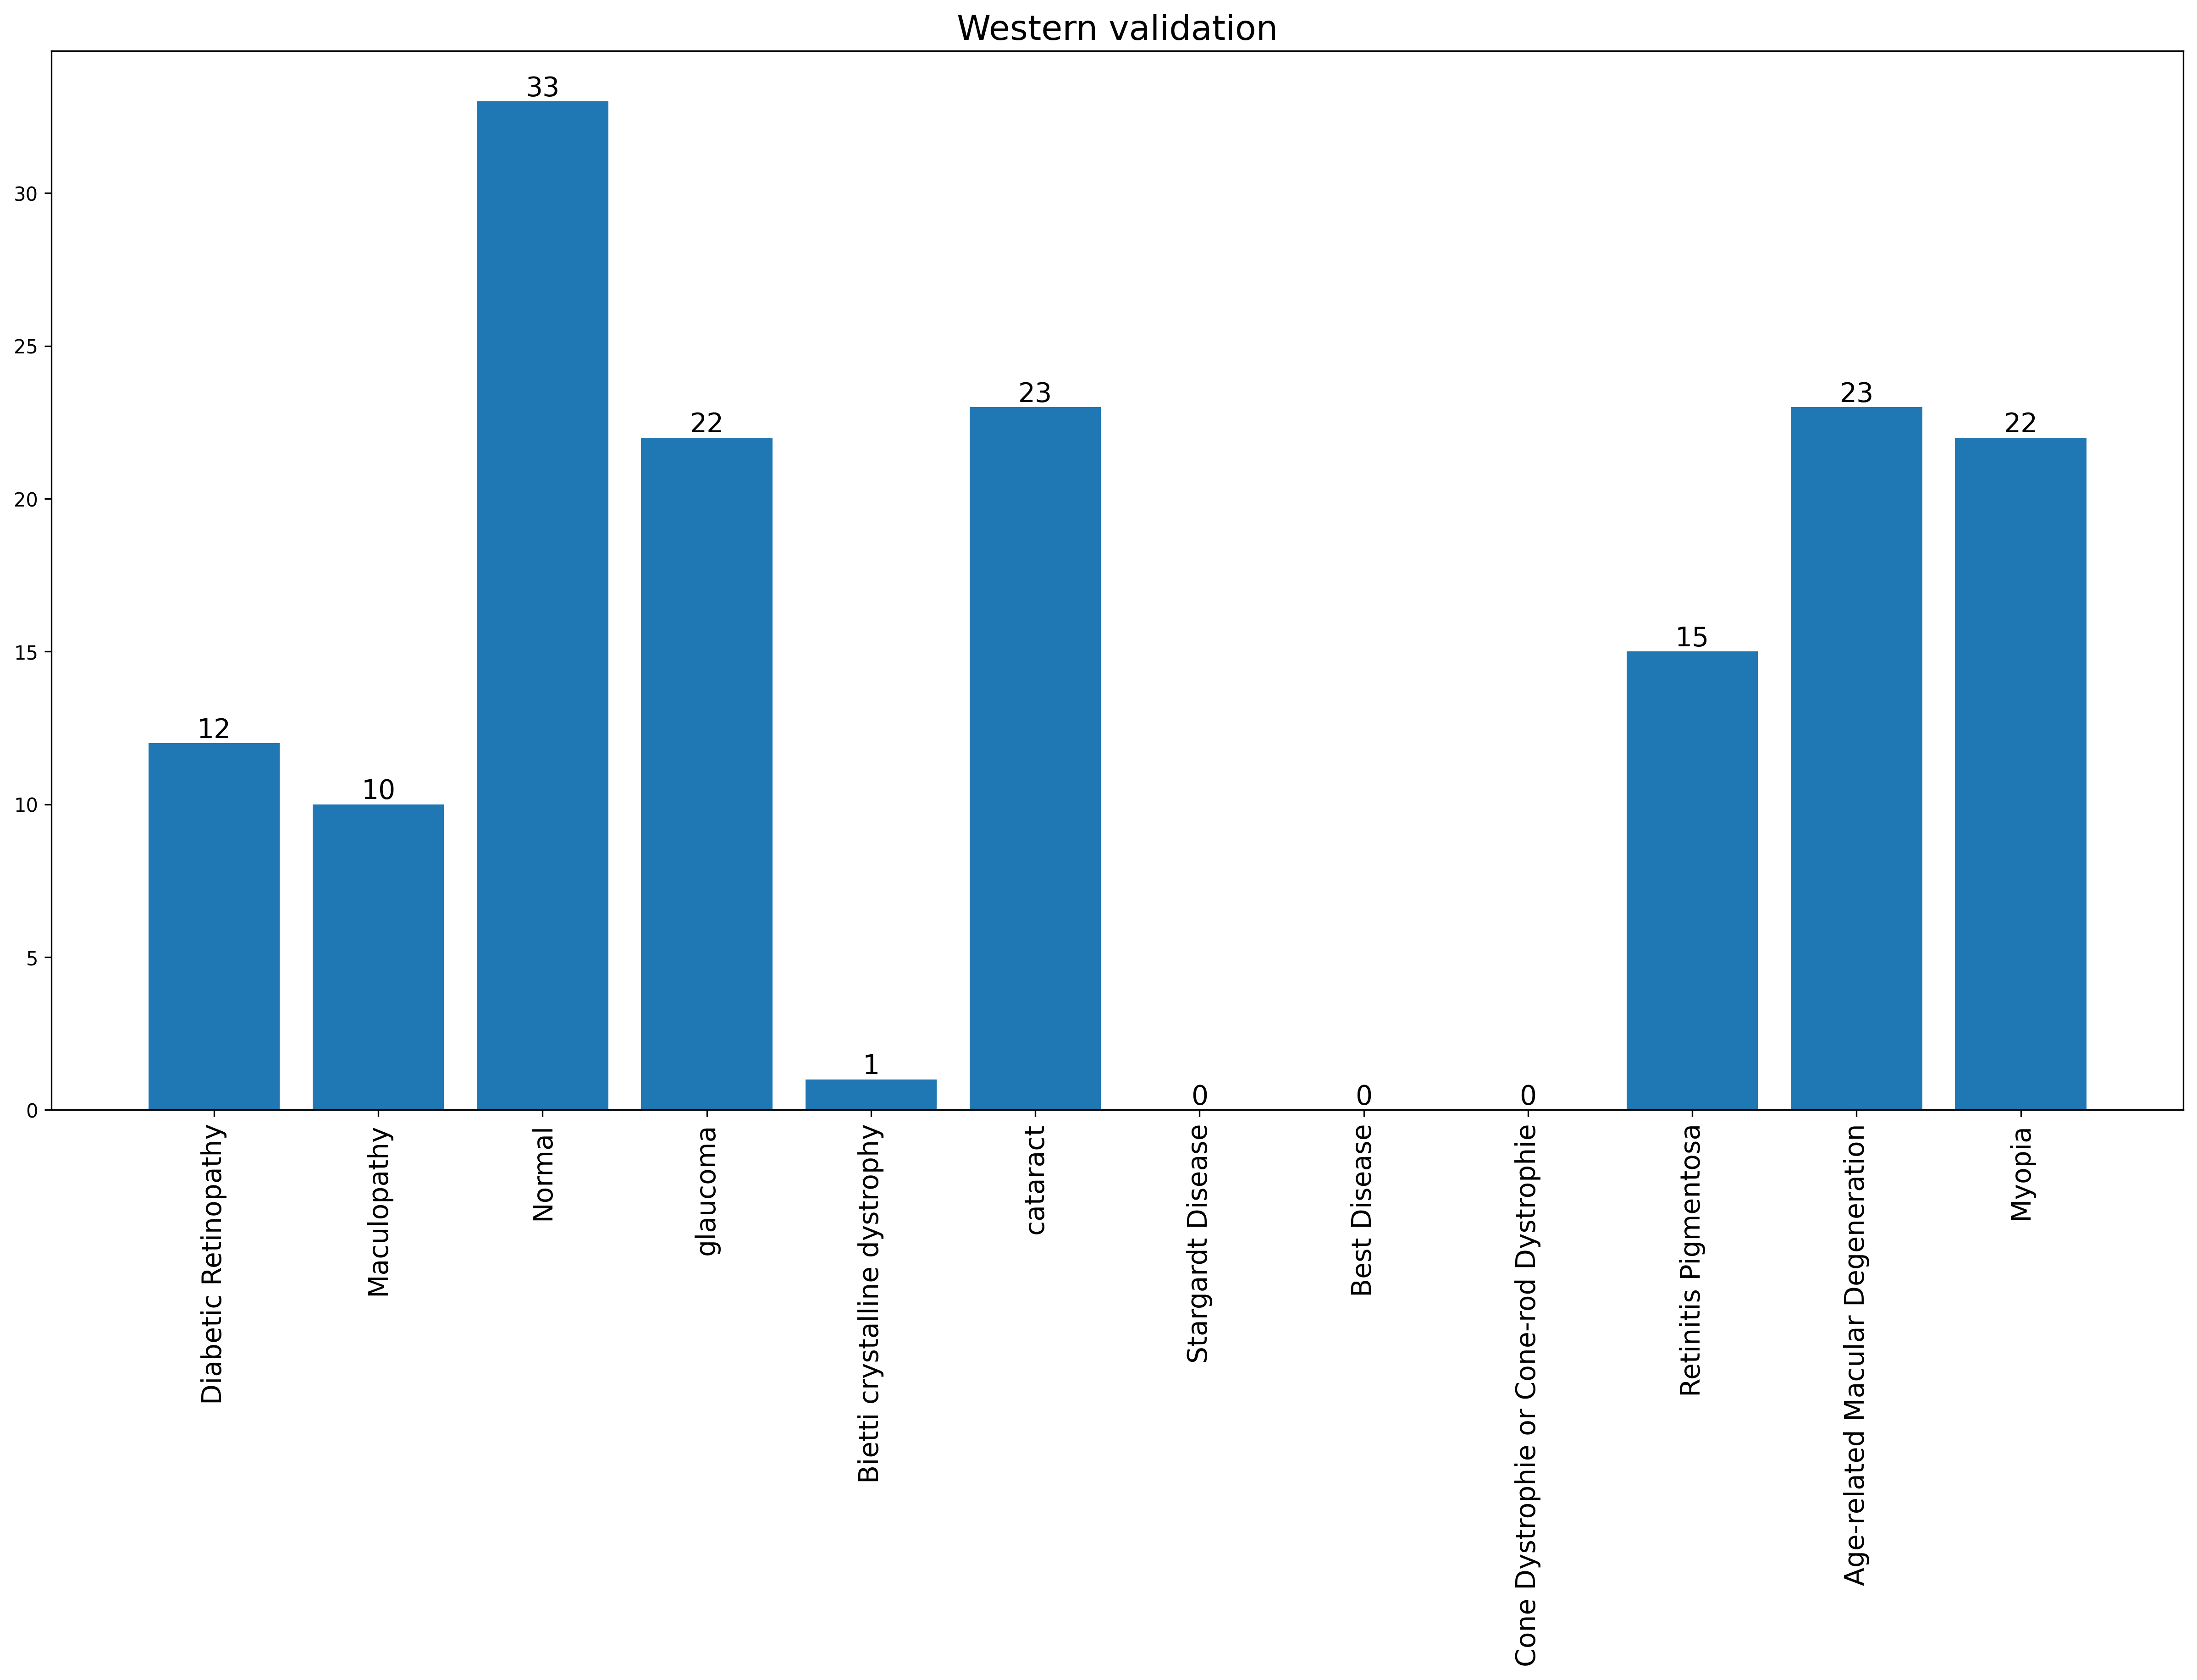

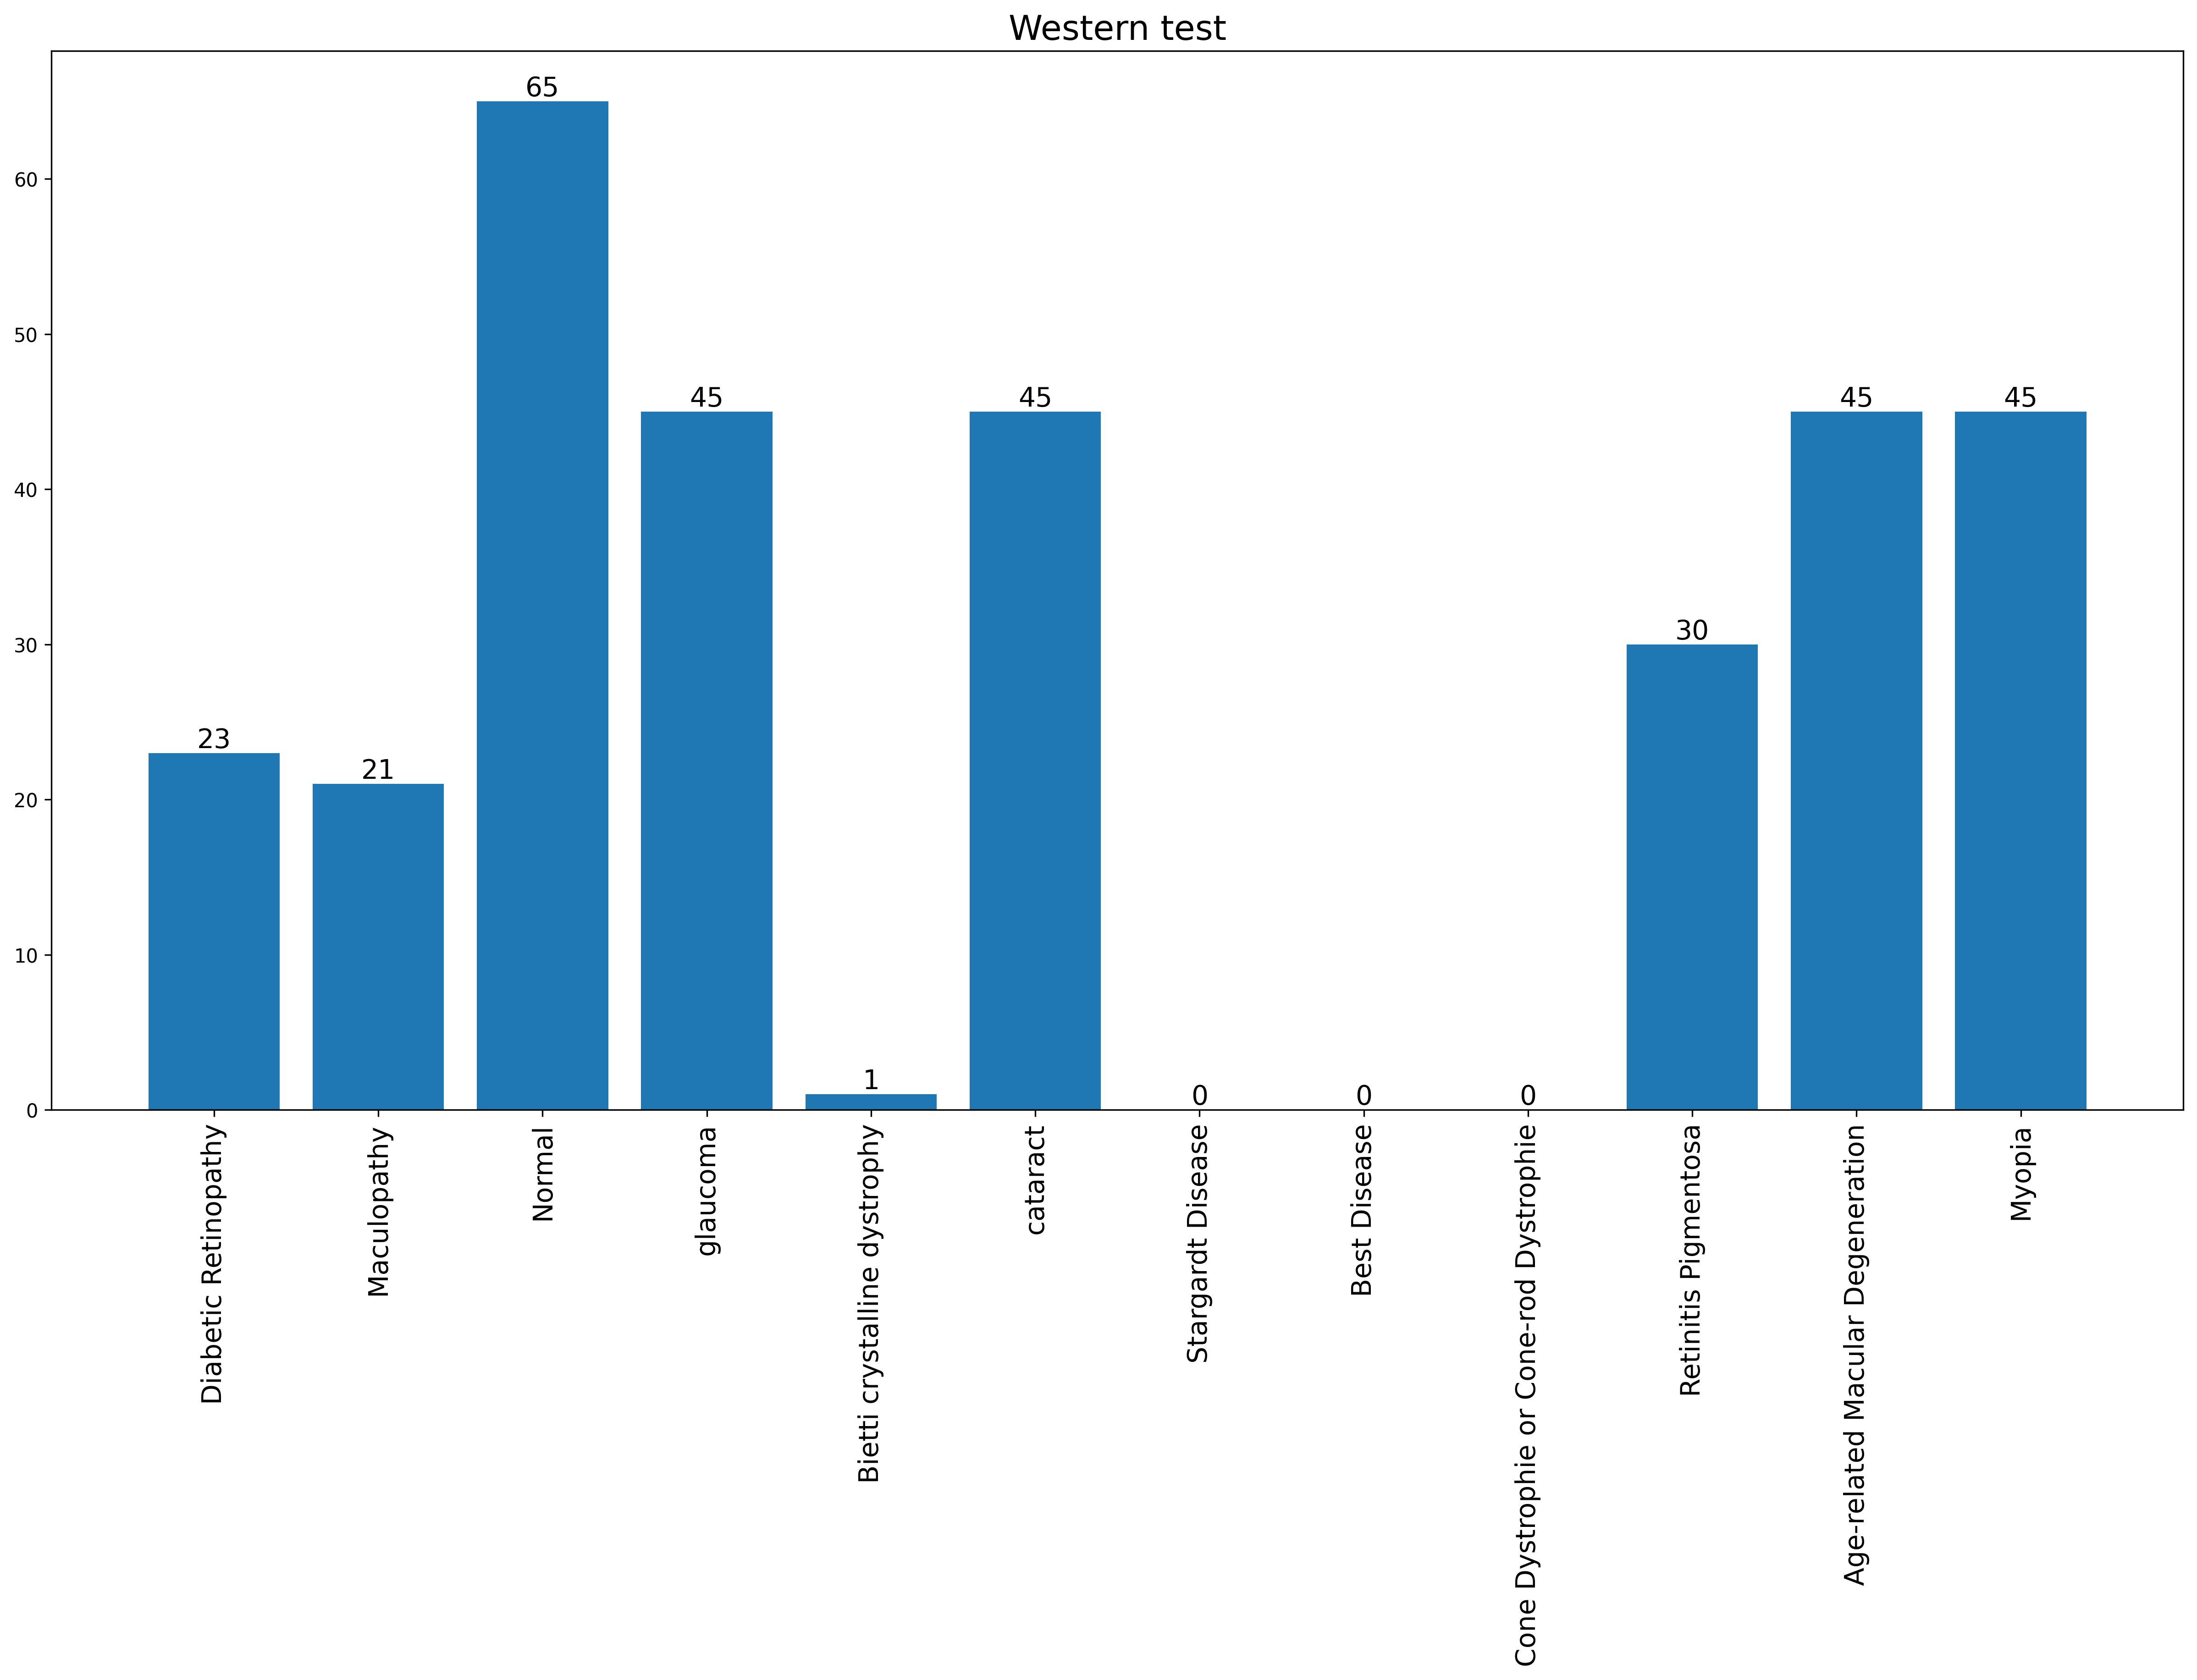

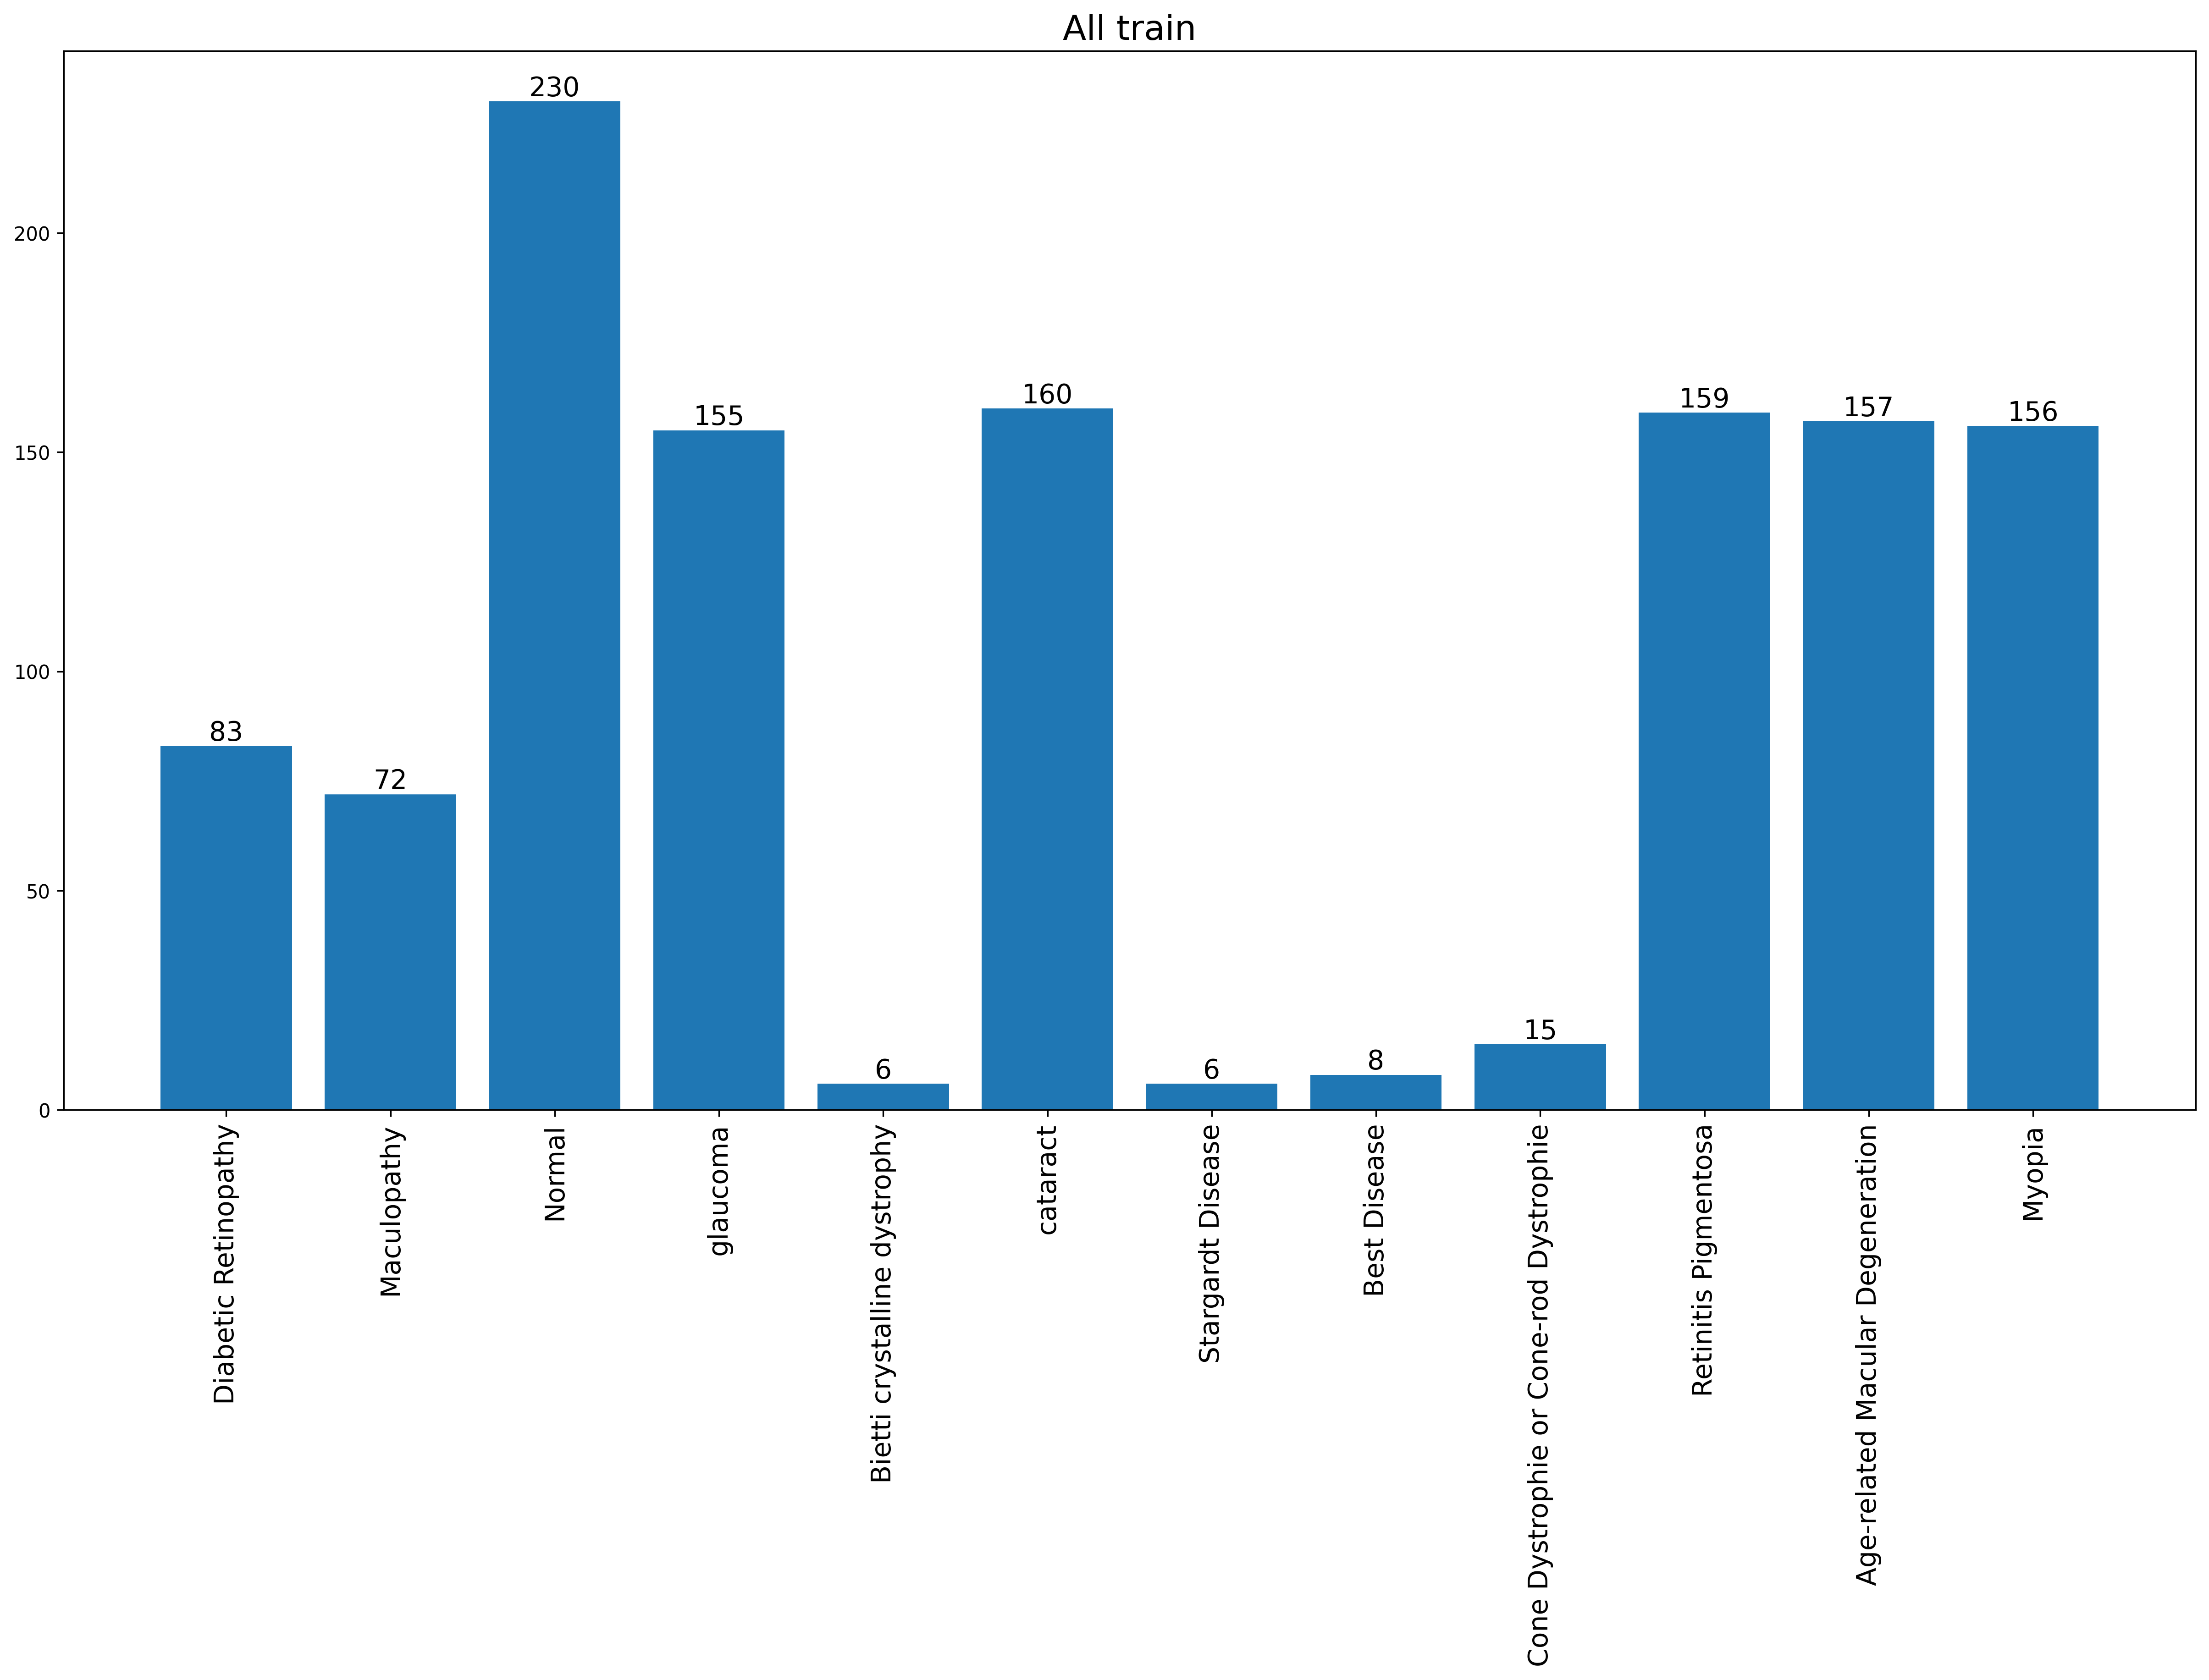

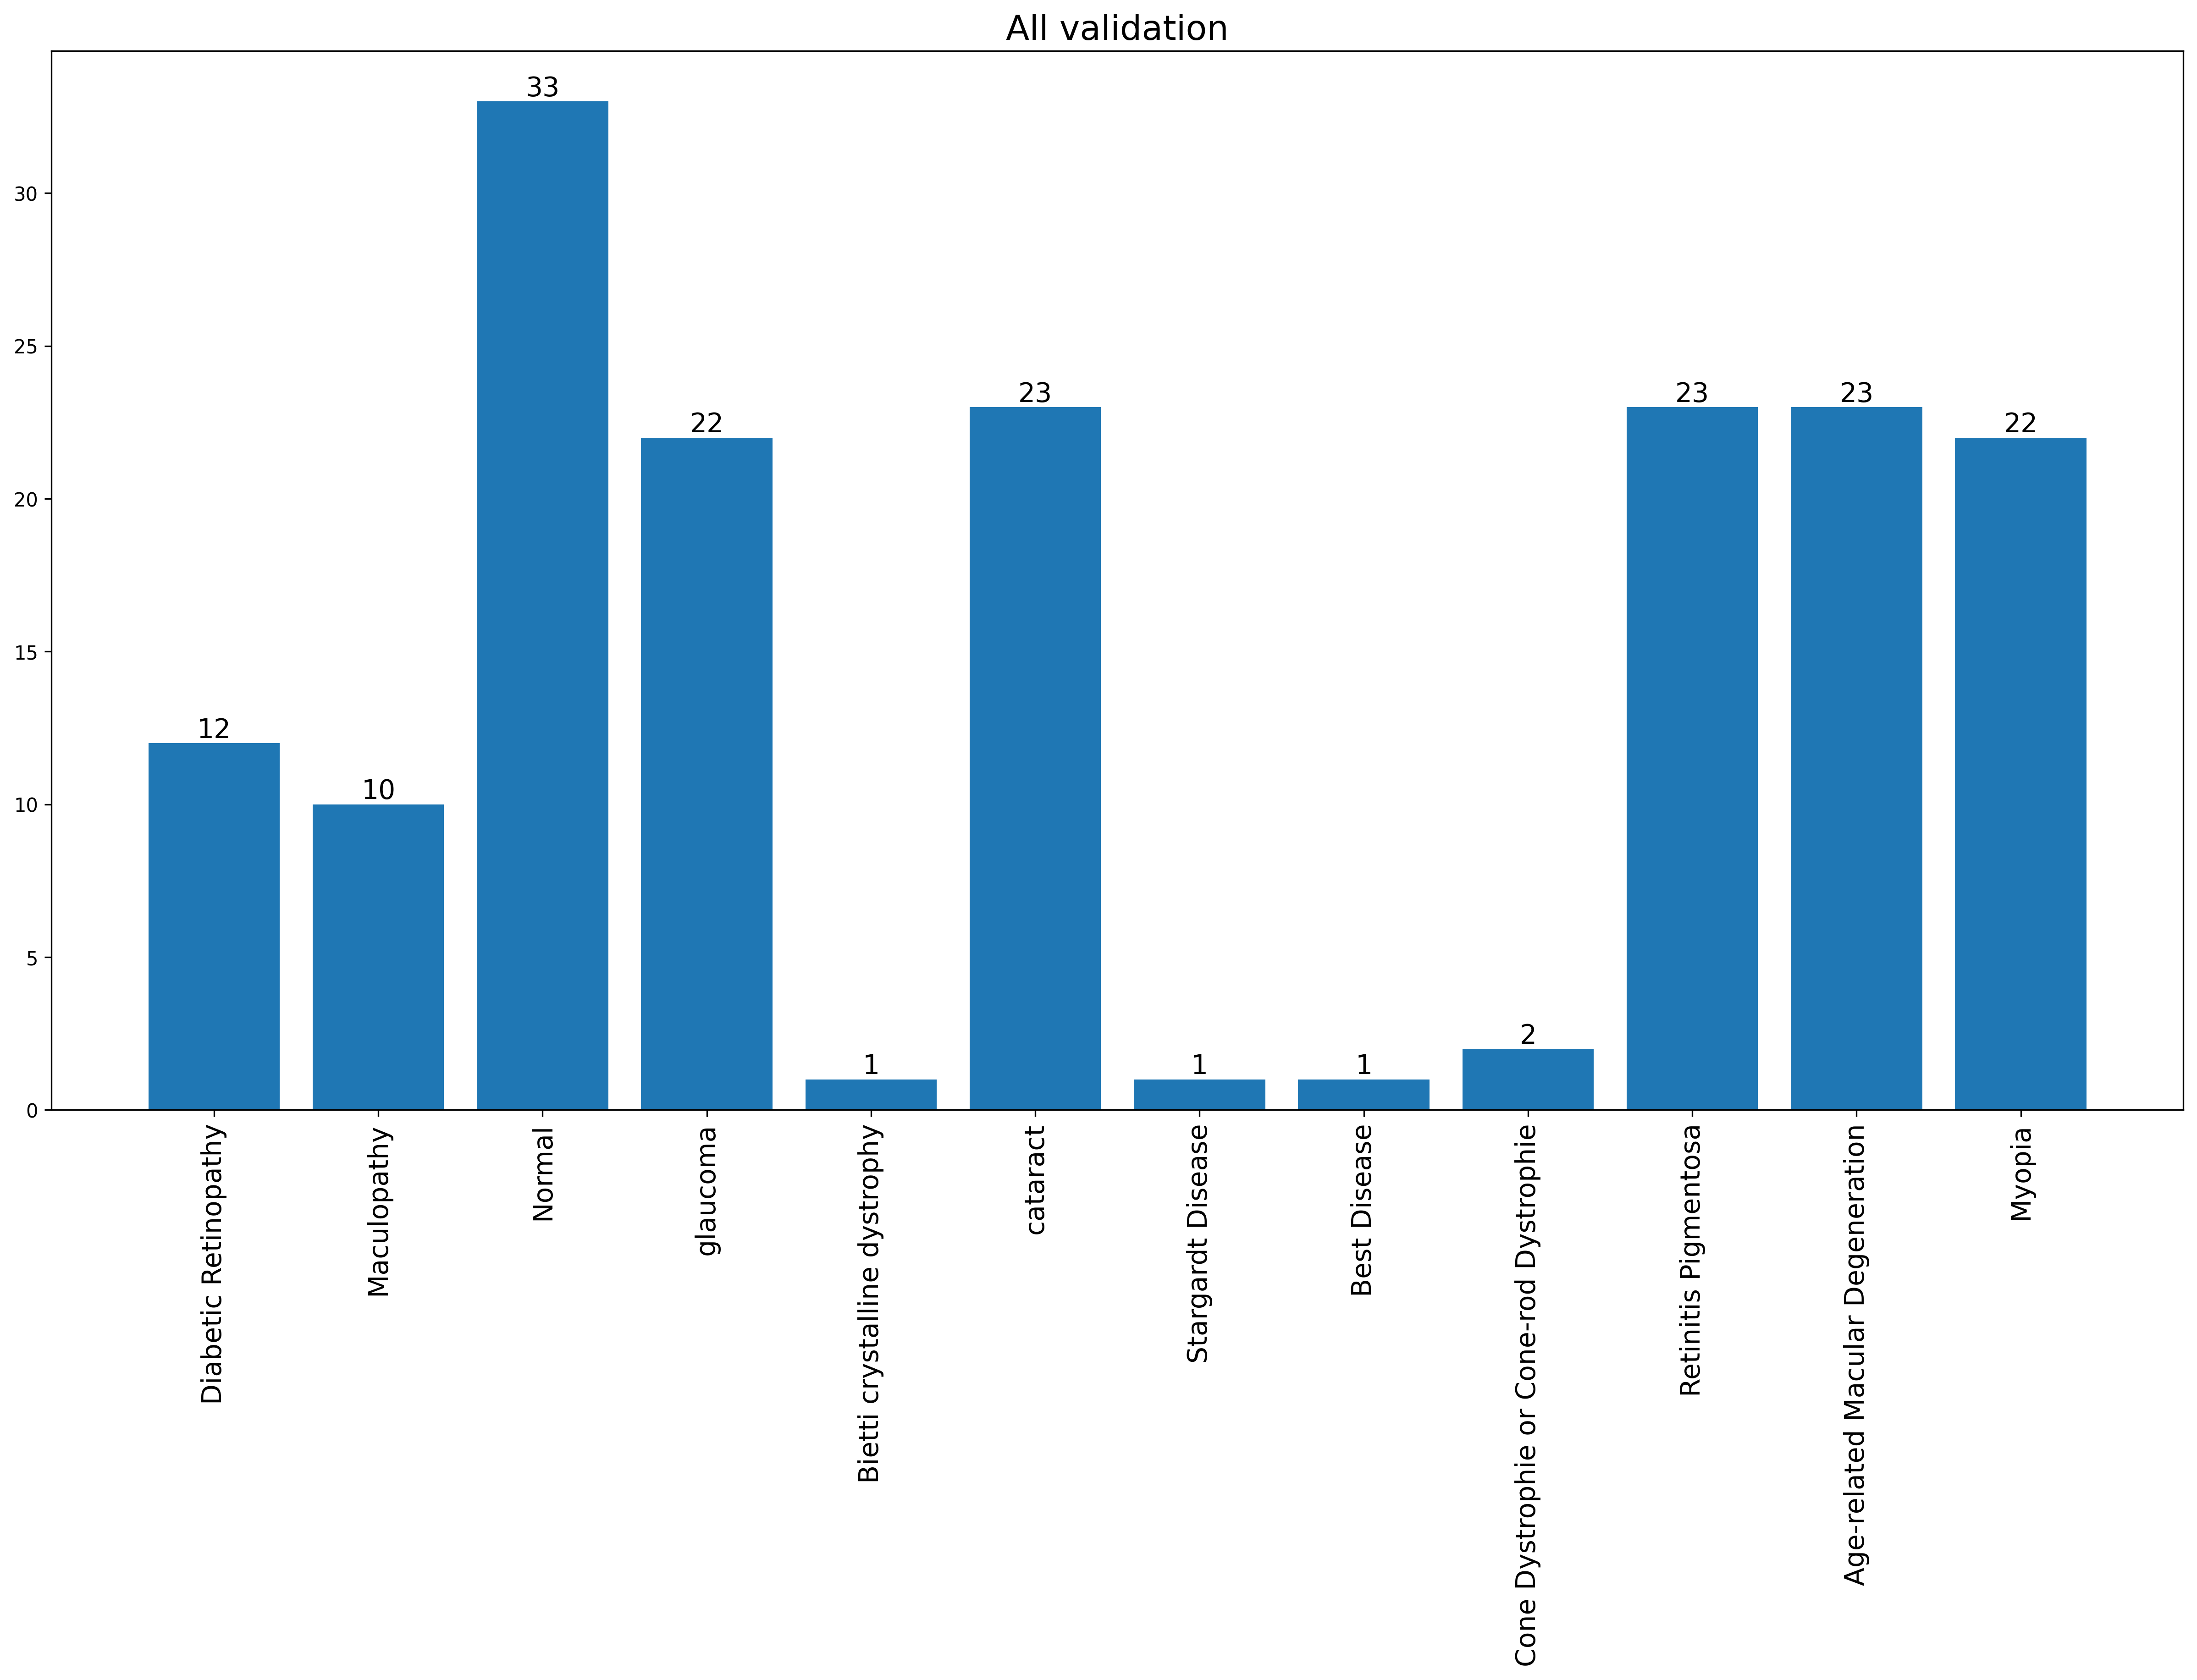

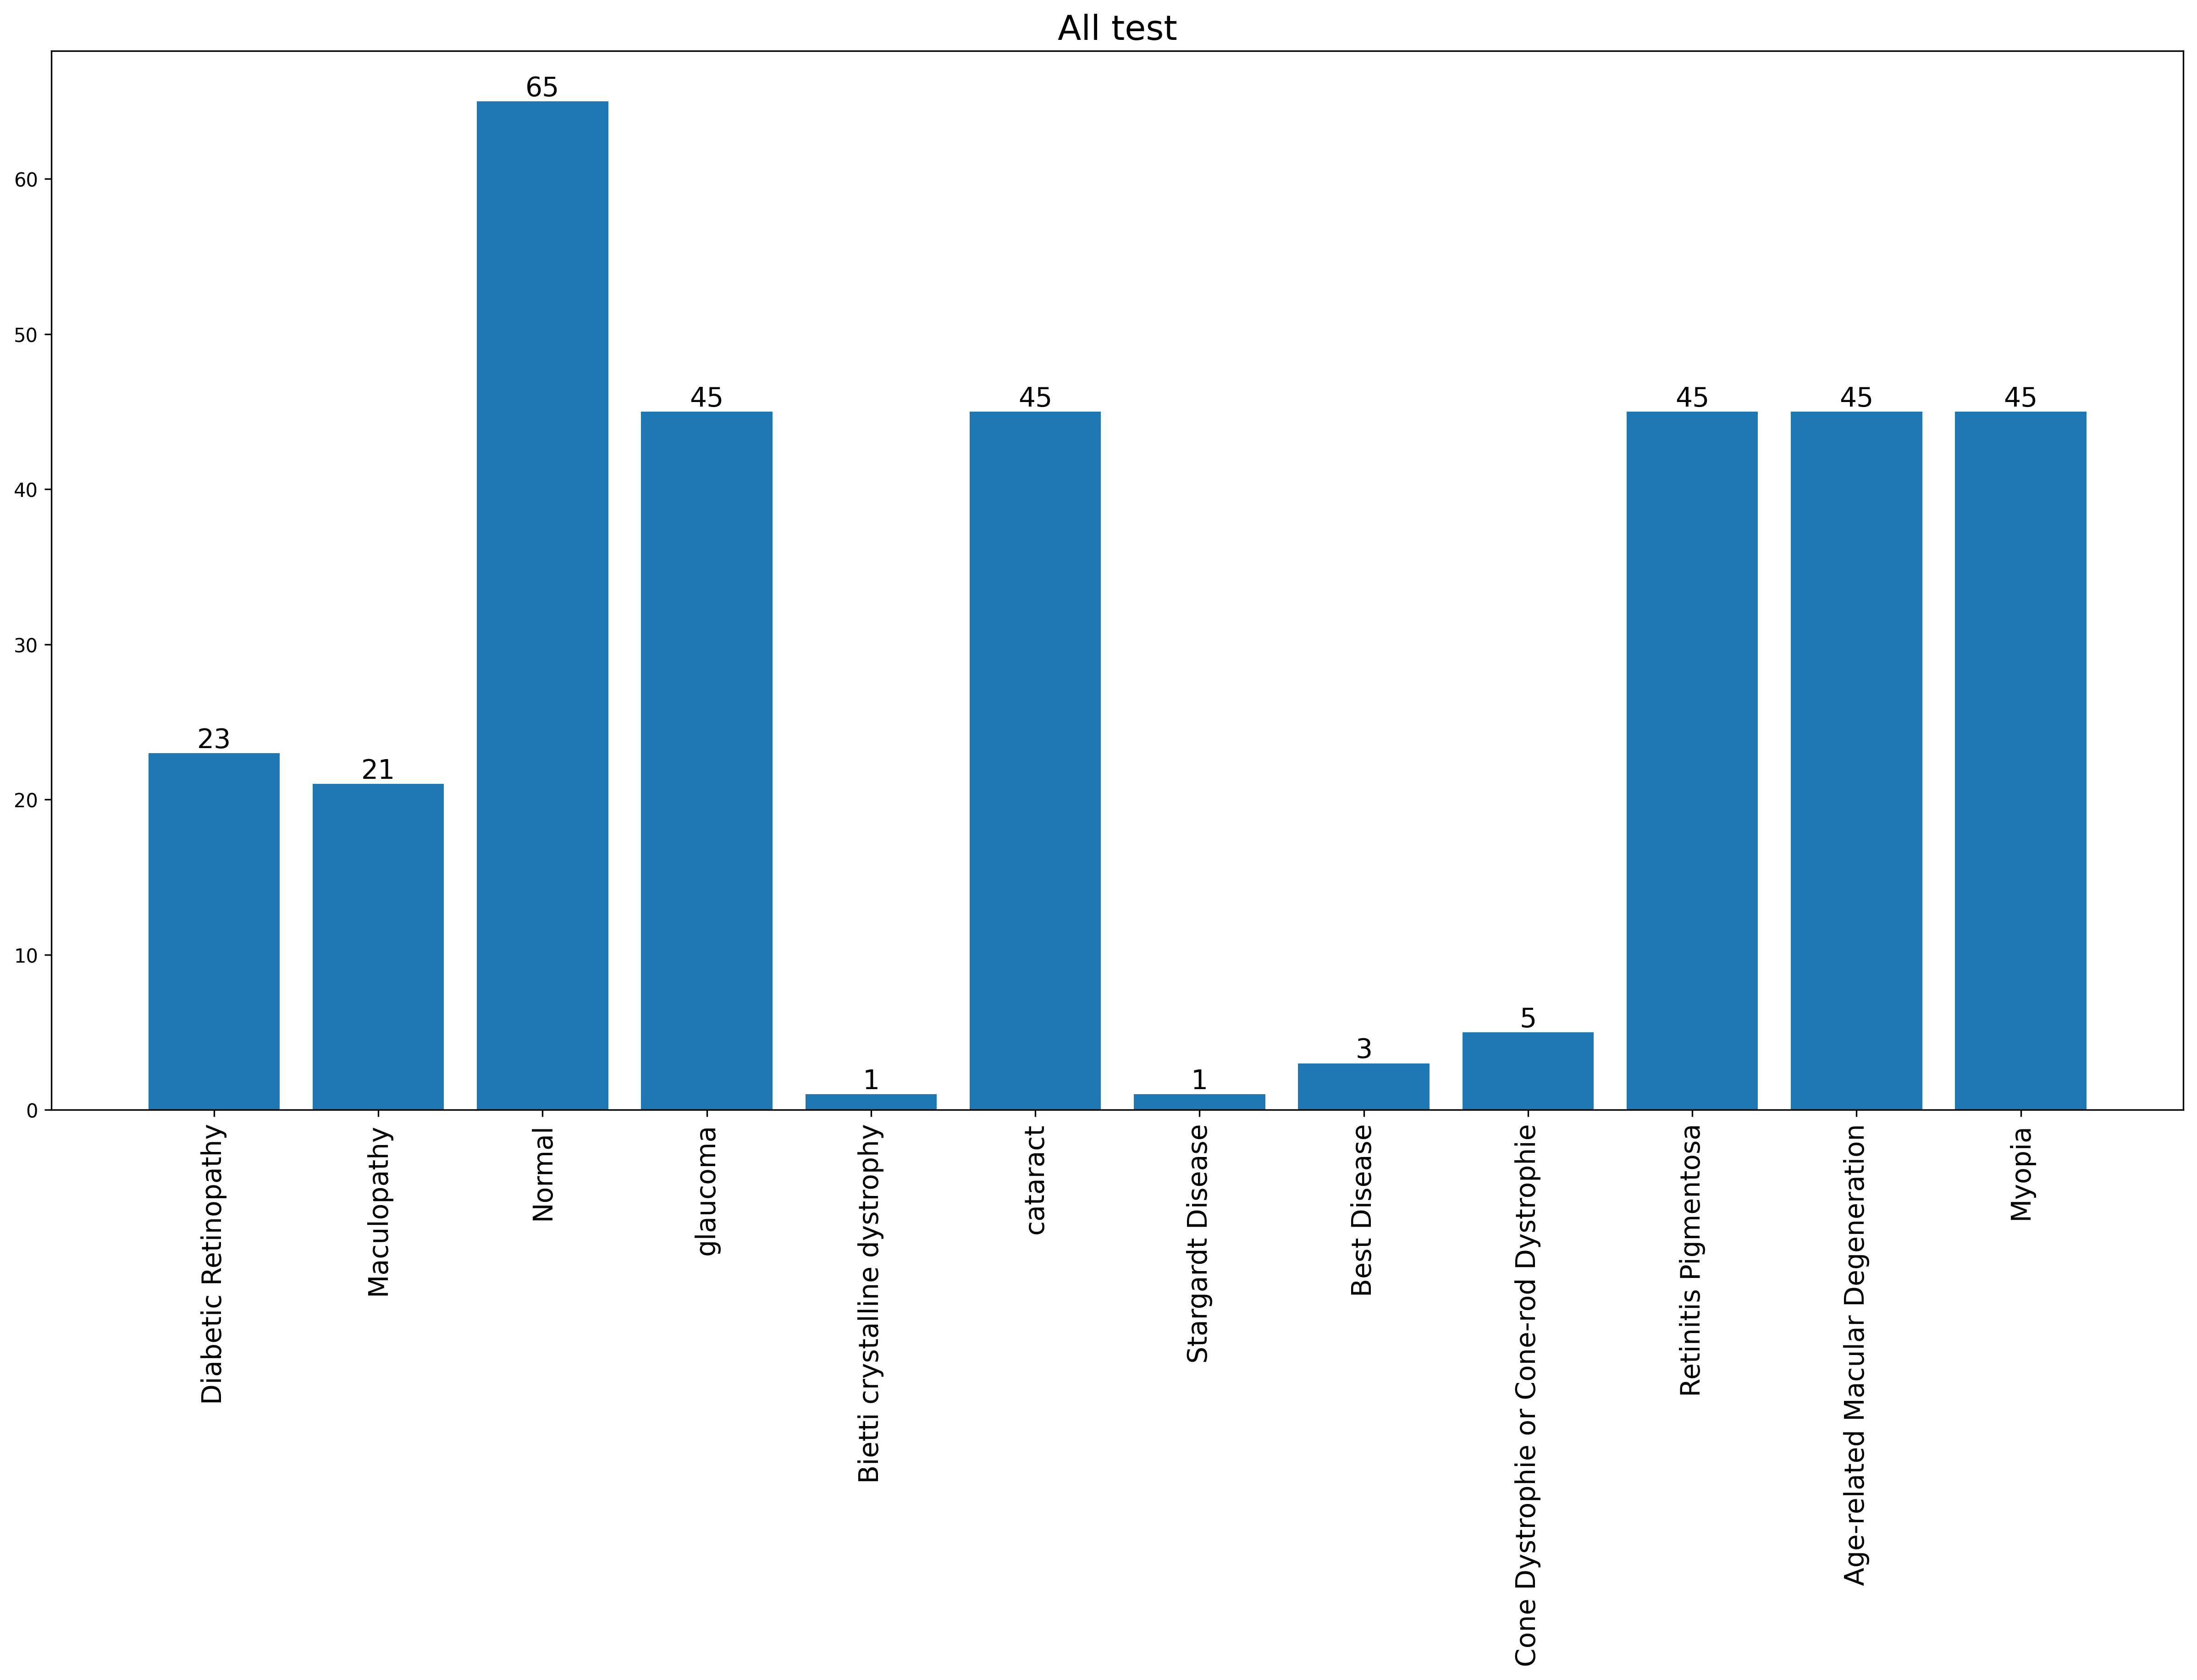

In [35]:
#plot the histogram of the disease keys for ses and western
# Count the number of instances for each class
for df_group, df_name in zip(stratified_dataframes, stratified_dataframes_names):
    for df, split_name in zip(df_group, split_names):
        counts = df[label_names].sum(axis=0)
        #plot the histogram
        plt.figure(figsize=(20, 10), dpi=300)
        plt.title(f'{df_name} {split_name}', fontsize=18)
        bars = plt.bar(counts.index, counts.values)
        plt.xticks(fontsize=14, rotation=90)
        # Annotate each bar with its height
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=14)

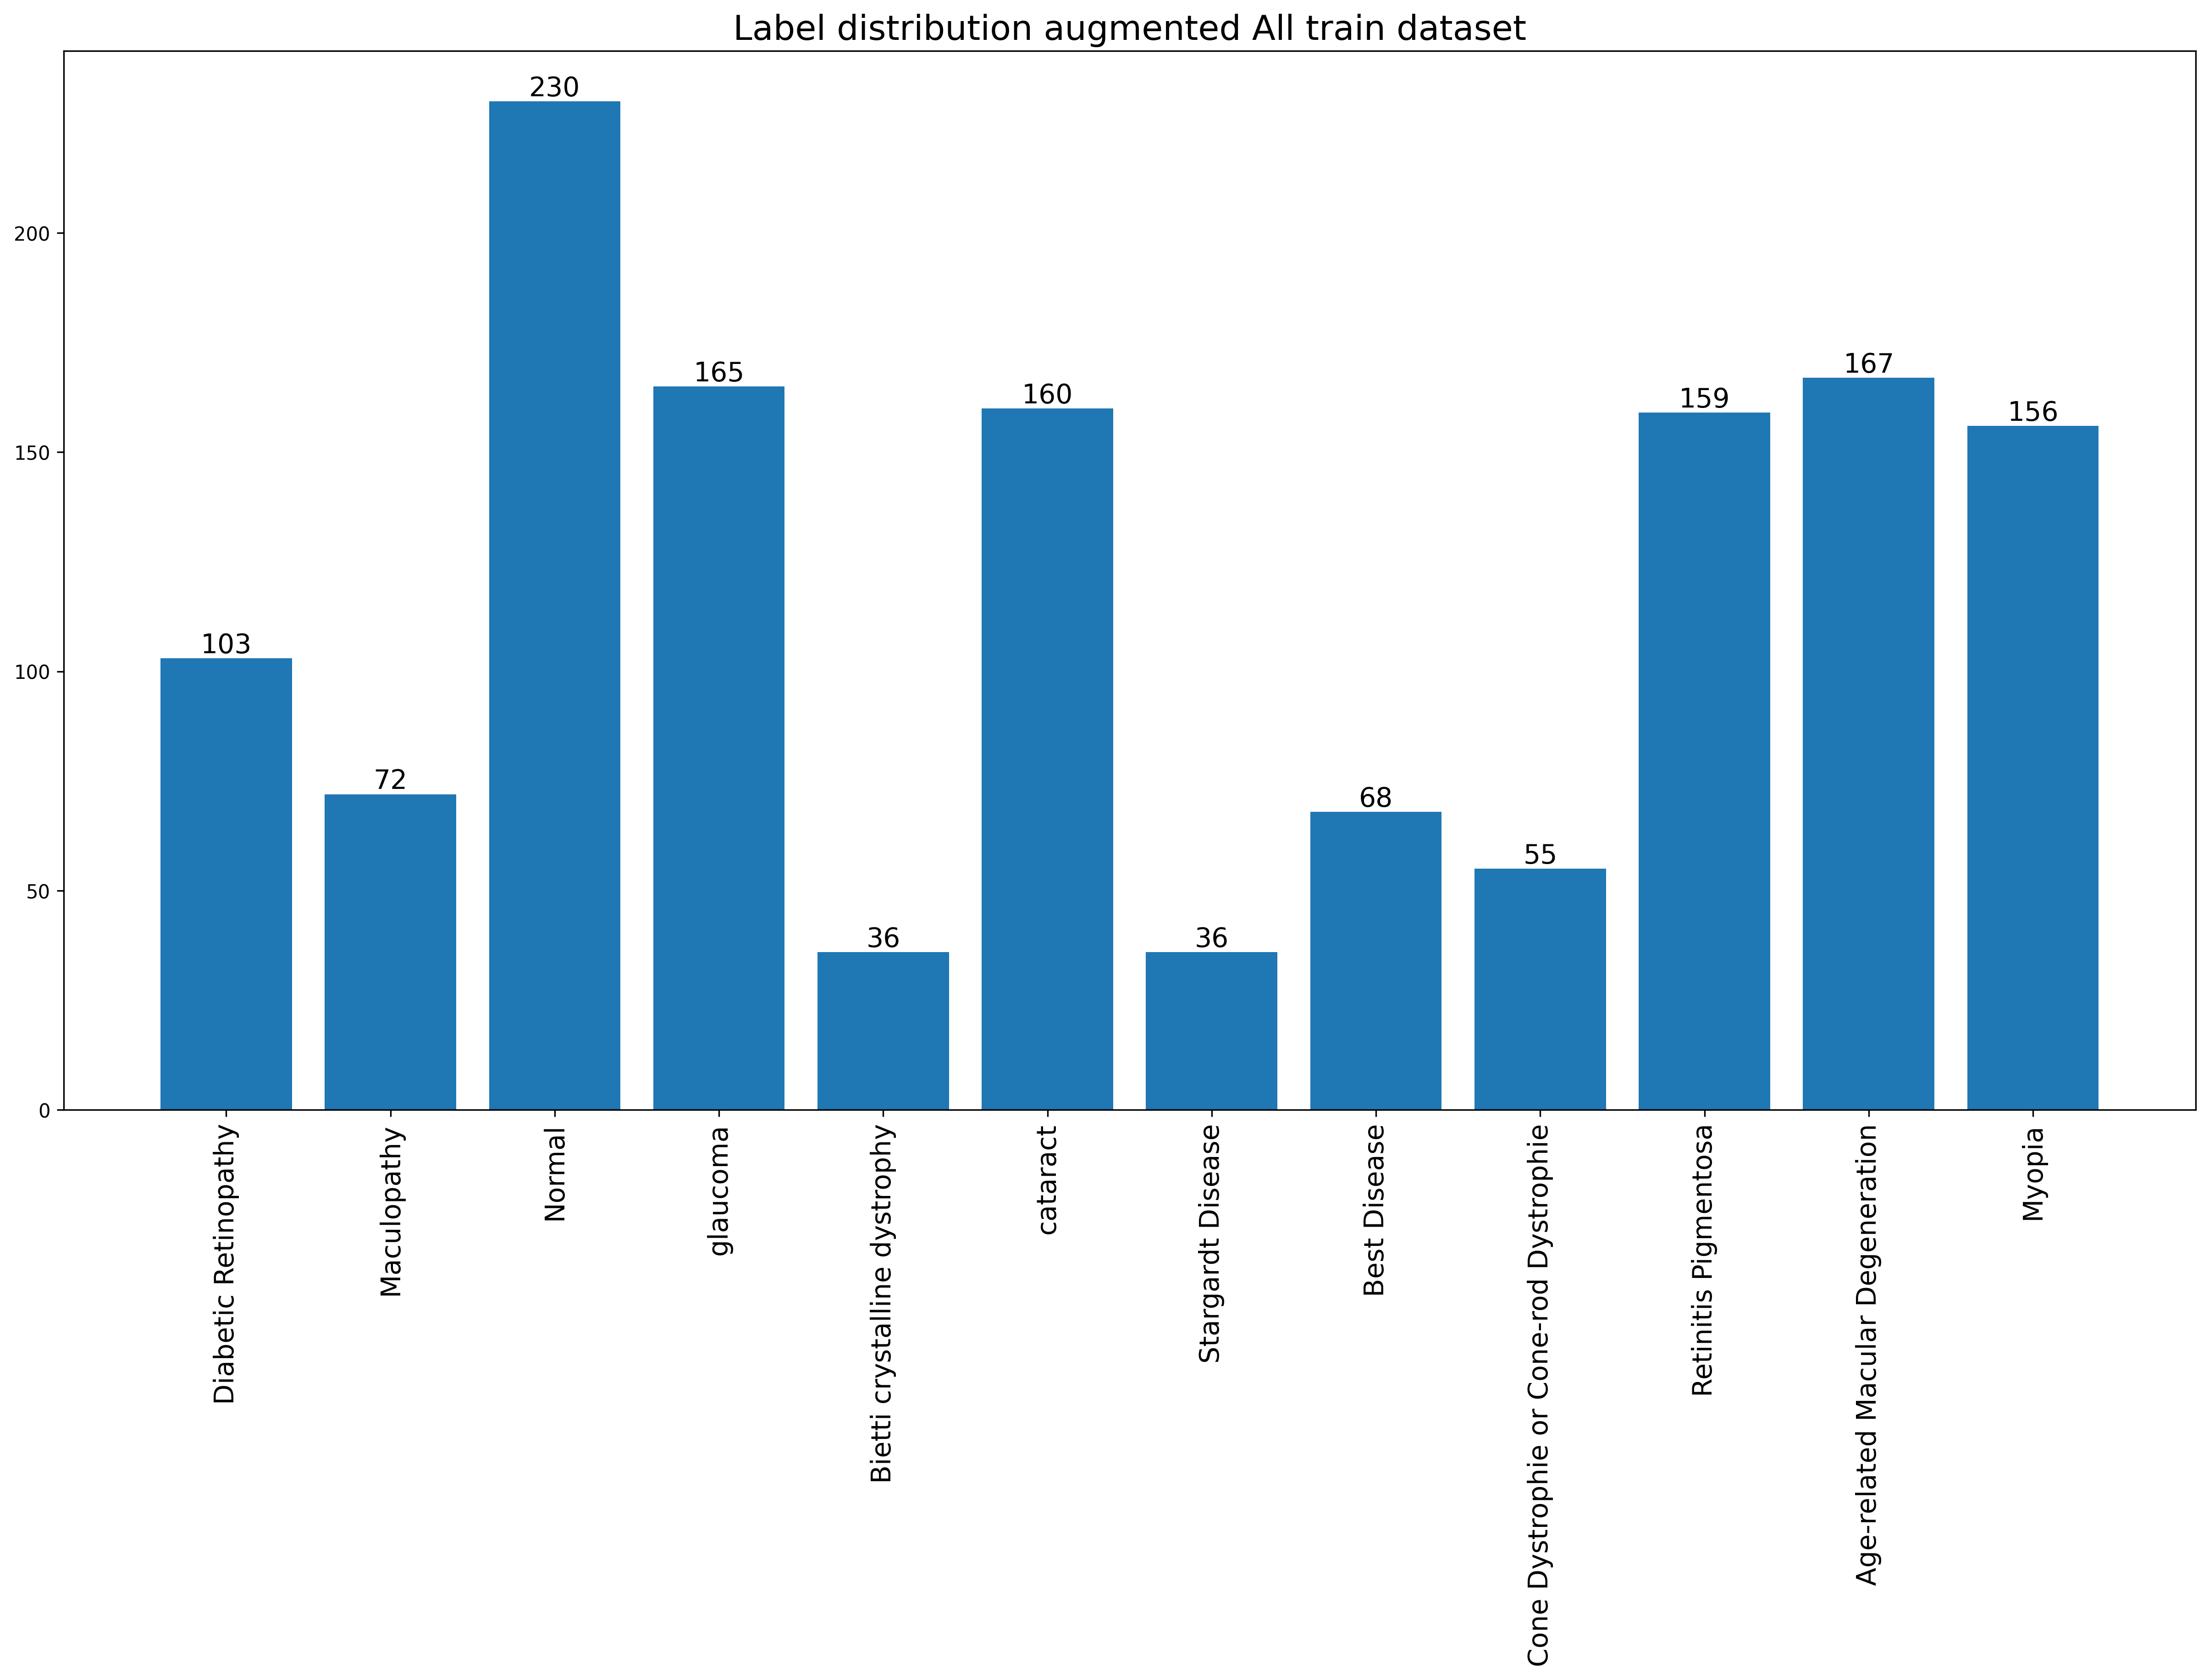

In [4]:
#load dataset_config.json
with open('datasets/2024-01-31_11-09-02/dataset_config.json') as json_file:
    dataset_config = json.load(json_file)
label_cols = dataset_config['label_names']
#load the df
df = pd.read_csv('models/resnet18/b4435d39-0c05-498d-8ac8-c4e38736cbed/train_dataset.csv')


counts = df[label_cols].sum(axis=0)
#plot the histogram
plt.figure(figsize=(20, 10), dpi=300)
plt.title(f'Label distribution augmented All train dataset', fontsize=18)
bars = plt.bar(counts.index, counts.values)
plt.xticks(fontsize=14, rotation=90)
# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=14)
#save the plot
plt.savefig('label_distribution.png')
plt.show()

In [36]:
#save the dataframes
save = True
dataset_path = f'datasets/{date}/'
if save:
    #check if the directory exists
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    for df_group, df_name in zip(stratified_dataframes, stratified_dataframes_names):
        for df, split_name in zip(df_group, split_names):
            df.to_csv(f'{dataset_path}{df_name}_{split_name}.csv', index=False)


In [48]:
#save a json file with the label names
path_to_img_column = 'path_to_img'
dataset_config = {'label_names': label_names, 'path_to_img_coulumn' : path_to_img_column}
with open(f'{dataset_path}dataset_config.json', 'w') as outfile:
    json.dump(dataset_config, outfile)

Step 11: create a dataset

In [37]:
class DfDataset(Dataset):
    def __init__(self, df, data_path_col : str, label_cols : list, transform=None, augmentation=False, shuffle=True):
        self.df = df
        #add do augmentation column
        self.df['do_augmentation'] = False
        self.transform = transform
        self.data_path_col = data_path_col
        self.label_cols = label_cols
        self.augmentation = augmentation
        self.classes = label_cols
        #create a list of possible transformations
        
        if self.augmentation:
            self.augmentations = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5)
            ])
            new_data = self.augment_data(img_paths=self.df[self.data_path_col].values, img_labels=self.df[self.label_cols].values, label_cols=self.label_cols)
            self.df = pd.concat([self.df, new_data], ignore_index=True)
            self.df = self.df.sample(frac=1).reset_index(drop=True)
        #shuffle data
        if shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row[self.data_path_col]).convert('RGB')
        label = torch.Tensor(row[self.label_cols].values.astype(np.int8)).float()
        if self.augmentation:
            img = self.augmentations(img)
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def calculate_class_weights(self):
        #calculate class weights
        class_weights = []
        for label_col in self.label_cols:
            class_weights.append(1 / self.df[label_col].sum(axis = 0))
        return class_weights
    
    def augment_data(self, img_paths : np.array, img_labels : np.array, label_cols : np.array, max_augmentations : int = 10, augmentation_threshold : float = 0.2):
        #todo implemnt better augmentation, get all images with label, n random picks, augment them, add them to the dataset
        #augment data
        class_weights = self.calculate_class_weights()
        min_class_weights = min(class_weights)
        max_class_weights = max(class_weights)
        new_img_paths = []
        do_augmentation = []
        #generate map
        new_img_labels = {label : [] for label in label_cols}
        for img_path, img_label in zip(img_paths, img_labels):
            #get img class weight
            img_class_weights = [weight for weight, label in zip(class_weights, img_label) if label == 1]
            max_class_weight = max(img_class_weights)
                #make augmentation decision based on uniform distribution
            if np.random.uniform(low=min_class_weights, high=max_class_weights) < max_class_weight*(1 - augmentation_threshold):
                for i in range(max_augmentations):
                    do_augmentation.append(True)
                    new_img_paths.append(img_path)
                    for label_key, label in zip(label_cols, img_label):
                        is_labeled_with_label = label == 1
                        #convert bol to int
                        is_labeled_with_label = int(is_labeled_with_label)
                        new_img_labels[label_key].append(is_labeled_with_label)
        
        #create new dataframe
        new_data = deepcopy(new_img_labels)
        new_data.update({self.data_path_col : new_img_paths, 'do_augmentation' : do_augmentation})
        new_data = pd.DataFrame(new_data)
        
        return new_data

In [38]:
import models_torch
from image_transforms import RectAngularPadTransform, ben_transform

In [39]:
normalization_transform = ben_transform(224)

In [40]:
model_key = 'resnet18'
model_transforms = models_torch.model_dict[model_key]['transforms']
no_normalizations_transforms = transforms.Compose([RectAngularPadTransform(),
                                                    transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset_normalized_images = DfDataset(df=X_train, data_path_col='path_to_img', label_cols=label_names, transform=normalization_transform,
                     augmentation=False, shuffle=False)
train_dataset_no_normalization = DfDataset(df=X_train, data_path_col='path_to_img', label_cols=label_names, transform=no_normalizations_transforms,
                     augmentation=False, shuffle=False)
num_classes = len(train_dataset_normalized_images.classes)
model = models_torch.get_model(model_name= model_key,pretrained=True, num_classes= num_classes)

In [41]:
validation_dataset_normalized_images = DfDataset(df=X_val, data_path_col='path_to_img', label_cols=label_names, transform=normalization_transform)
validation_dataset_no_normalization = DfDataset(df=X_val, data_path_col='path_to_img', label_cols=label_names, transform=no_normalizations_transforms)


Text(0.5, 1.0, 'Ben Enhancement')

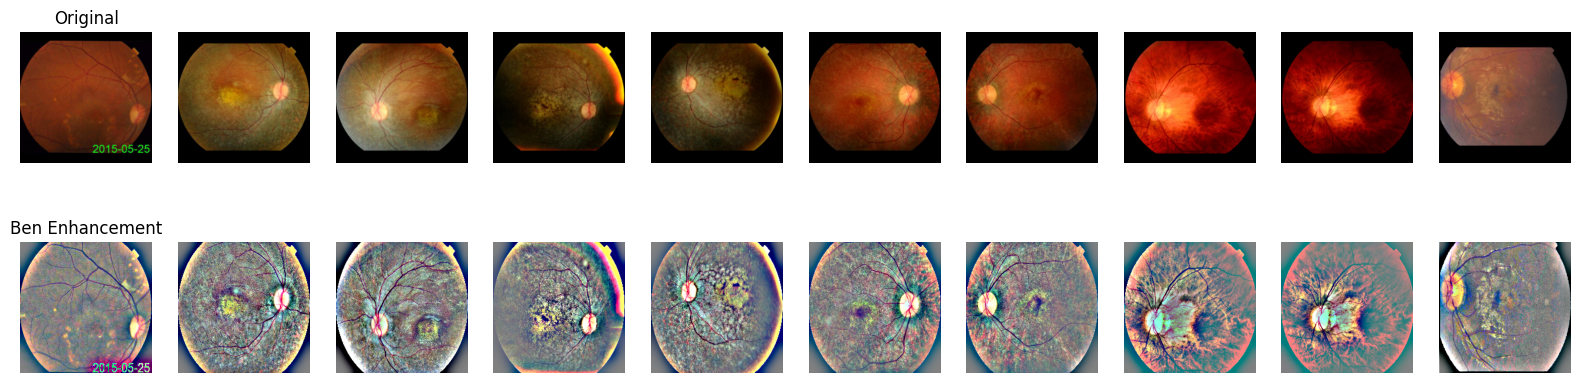

In [42]:
#plot some images from both datasets to compare the normalization
n_images_to_plot = 10
fig, axes = plt.subplots(nrows=2, ncols=n_images_to_plot, figsize=(20, 5))
plt.axis('off')
start_idx = 7
assert len(train_dataset_normalized_images) == len(train_dataset_no_normalization) == len(X_train)
for i in range(start_idx, start_idx + n_images_to_plot):
    img_normalized, label_normalized = train_dataset_normalized_images[i]
    img_no_normalized, label_no_normalized = train_dataset_no_normalization[i]
    axes[0, i - start_idx].imshow(img_no_normalized.permute(1, 2, 0))
    axes[1, i - start_idx].imshow(img_normalized.permute(1, 2, 0))
    #turn off axis
    axes[0, i - start_idx].axis('off')
    axes[1, i - start_idx].axis('off')
#set title for each row
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Ben Enhancement')

Step 12: train a model

In [43]:
from pattern.metrics.multi_label_metrics import multi_label_recal, multi_label_precision, multi_label_f_beta, multi_label_accuracy


In [44]:
#train the model
train_dataloader = DataLoader(train_dataset_normalized_images, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset_normalized_images, batch_size=32, shuffle=False)
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#train the model
#initialize the device which to use
metric_dict = {'train' : {'loss' : [], 'recall' : [], 'precision' : [], 'f_beta' : [], 'accuracy' : []},
                'validation' : {'loss' : [], 'recall' : [], 'precision' : [], 'f_beta' : [], 'accuracy' : []}}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss_function.to(device)
#train the model
num_epochs = 10
epoch_progress_bar = tqdm(range(num_epochs))

train = True
if train:
    for epoch in epoch_progress_bar:
        train_predictions = []
        train_labels = []
        model.train()
        for data, labels in train_dataloader:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            train_predictions.append(outputs)
            train_labels.append(labels)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        #calculate average loss
        all_predictions = torch.cat(train_predictions, dim=0)
        all_labels = torch.cat(train_labels, dim=0)
        avg_loss = loss_function(all_predictions.detach().clone(), all_labels.detach().clone())
        #calculate metrics
        recal = multi_label_recal(all_predictions.detach().clone(), all_labels.detach().clone(), average='macro')
        precision = multi_label_precision(all_predictions.detach().clone(), all_labels.detach().clone(), average='macro')
        f_beta = multi_label_f_beta(all_predictions.detach().clone(), all_labels.detach().clone(), average='macro')
        accuracy = multi_label_accuracy(all_predictions.detach().clone(), all_labels.detach().clone(), average='macro')
        #update metric dict
        metric_dict['train']['loss'].append(avg_loss), metric_dict['train']['recall'].append(recal), metric_dict['train']['precision'].append(precision)
        metric_dict['train']['f_beta'].append(f_beta), metric_dict['train']['accuracy'].append(accuracy)
        #update progress bar
        epoch_progress_bar.set_description(f'Epoch train: {epoch}, Loss: {avg_loss:.4f}, Recall: {recal:.4f}, Precision: {precision:.4f}, F-Beta: {f_beta:.4f}, Accuracy: {accuracy:.4f}')
        #run validation
        validation_predictions = []
        validation_labels = []
        model.eval()
        with torch.no_grad():
            for data, labels in validation_dataloader:
                data = data.to(device)
                labels = labels.to(device)
                outputs = model(data)
                validation_predictions.append(outputs)
                validation_labels.append(labels)
        #calculate average loss
        all_predictions = torch.cat(validation_predictions, dim=0)
        all_labels = torch.cat(validation_labels, dim=0)
        avg_loss = loss_function(all_predictions.detach().clone(), all_labels.detach().clone())
        #calculate metrics
        recal = multi_label_recal(all_predictions.detach().clone(), all_labels.detach().clone(), average='macro')
        precision = multi_label_precision(all_predictions.detach().clone(), all_labels.detach().clone(), average='macro')
        f_beta = multi_label_f_beta(all_predictions.detach().clone(), all_labels.detach().clone(), average='macro')
        accuracy = multi_label_accuracy(all_predictions.detach().clone(), all_labels.detach().clone(), average='macro')
        #update metric dict
        metric_dict['validation']['loss'].append(avg_loss), metric_dict['validation']['recall'].append(recal)
        metric_dict['validation']['precision'].append(precision), metric_dict['validation']['f_beta'].append(f_beta)
        metric_dict['validation']['accuracy'].append(accuracy)
        #update progress bar
        epoch_progress_bar.set_description(f'Epoch validation: {epoch}, Loss: {avg_loss:.4f}, Recall: {recal:.4f}, Precision: {precision:.4f}, F-Beta: {f_beta:.4f}, Accuracy: {accuracy:.4f}')


  0%|          | 0/10 [00:44<?, ?it/s]


KeyboardInterrupt: 

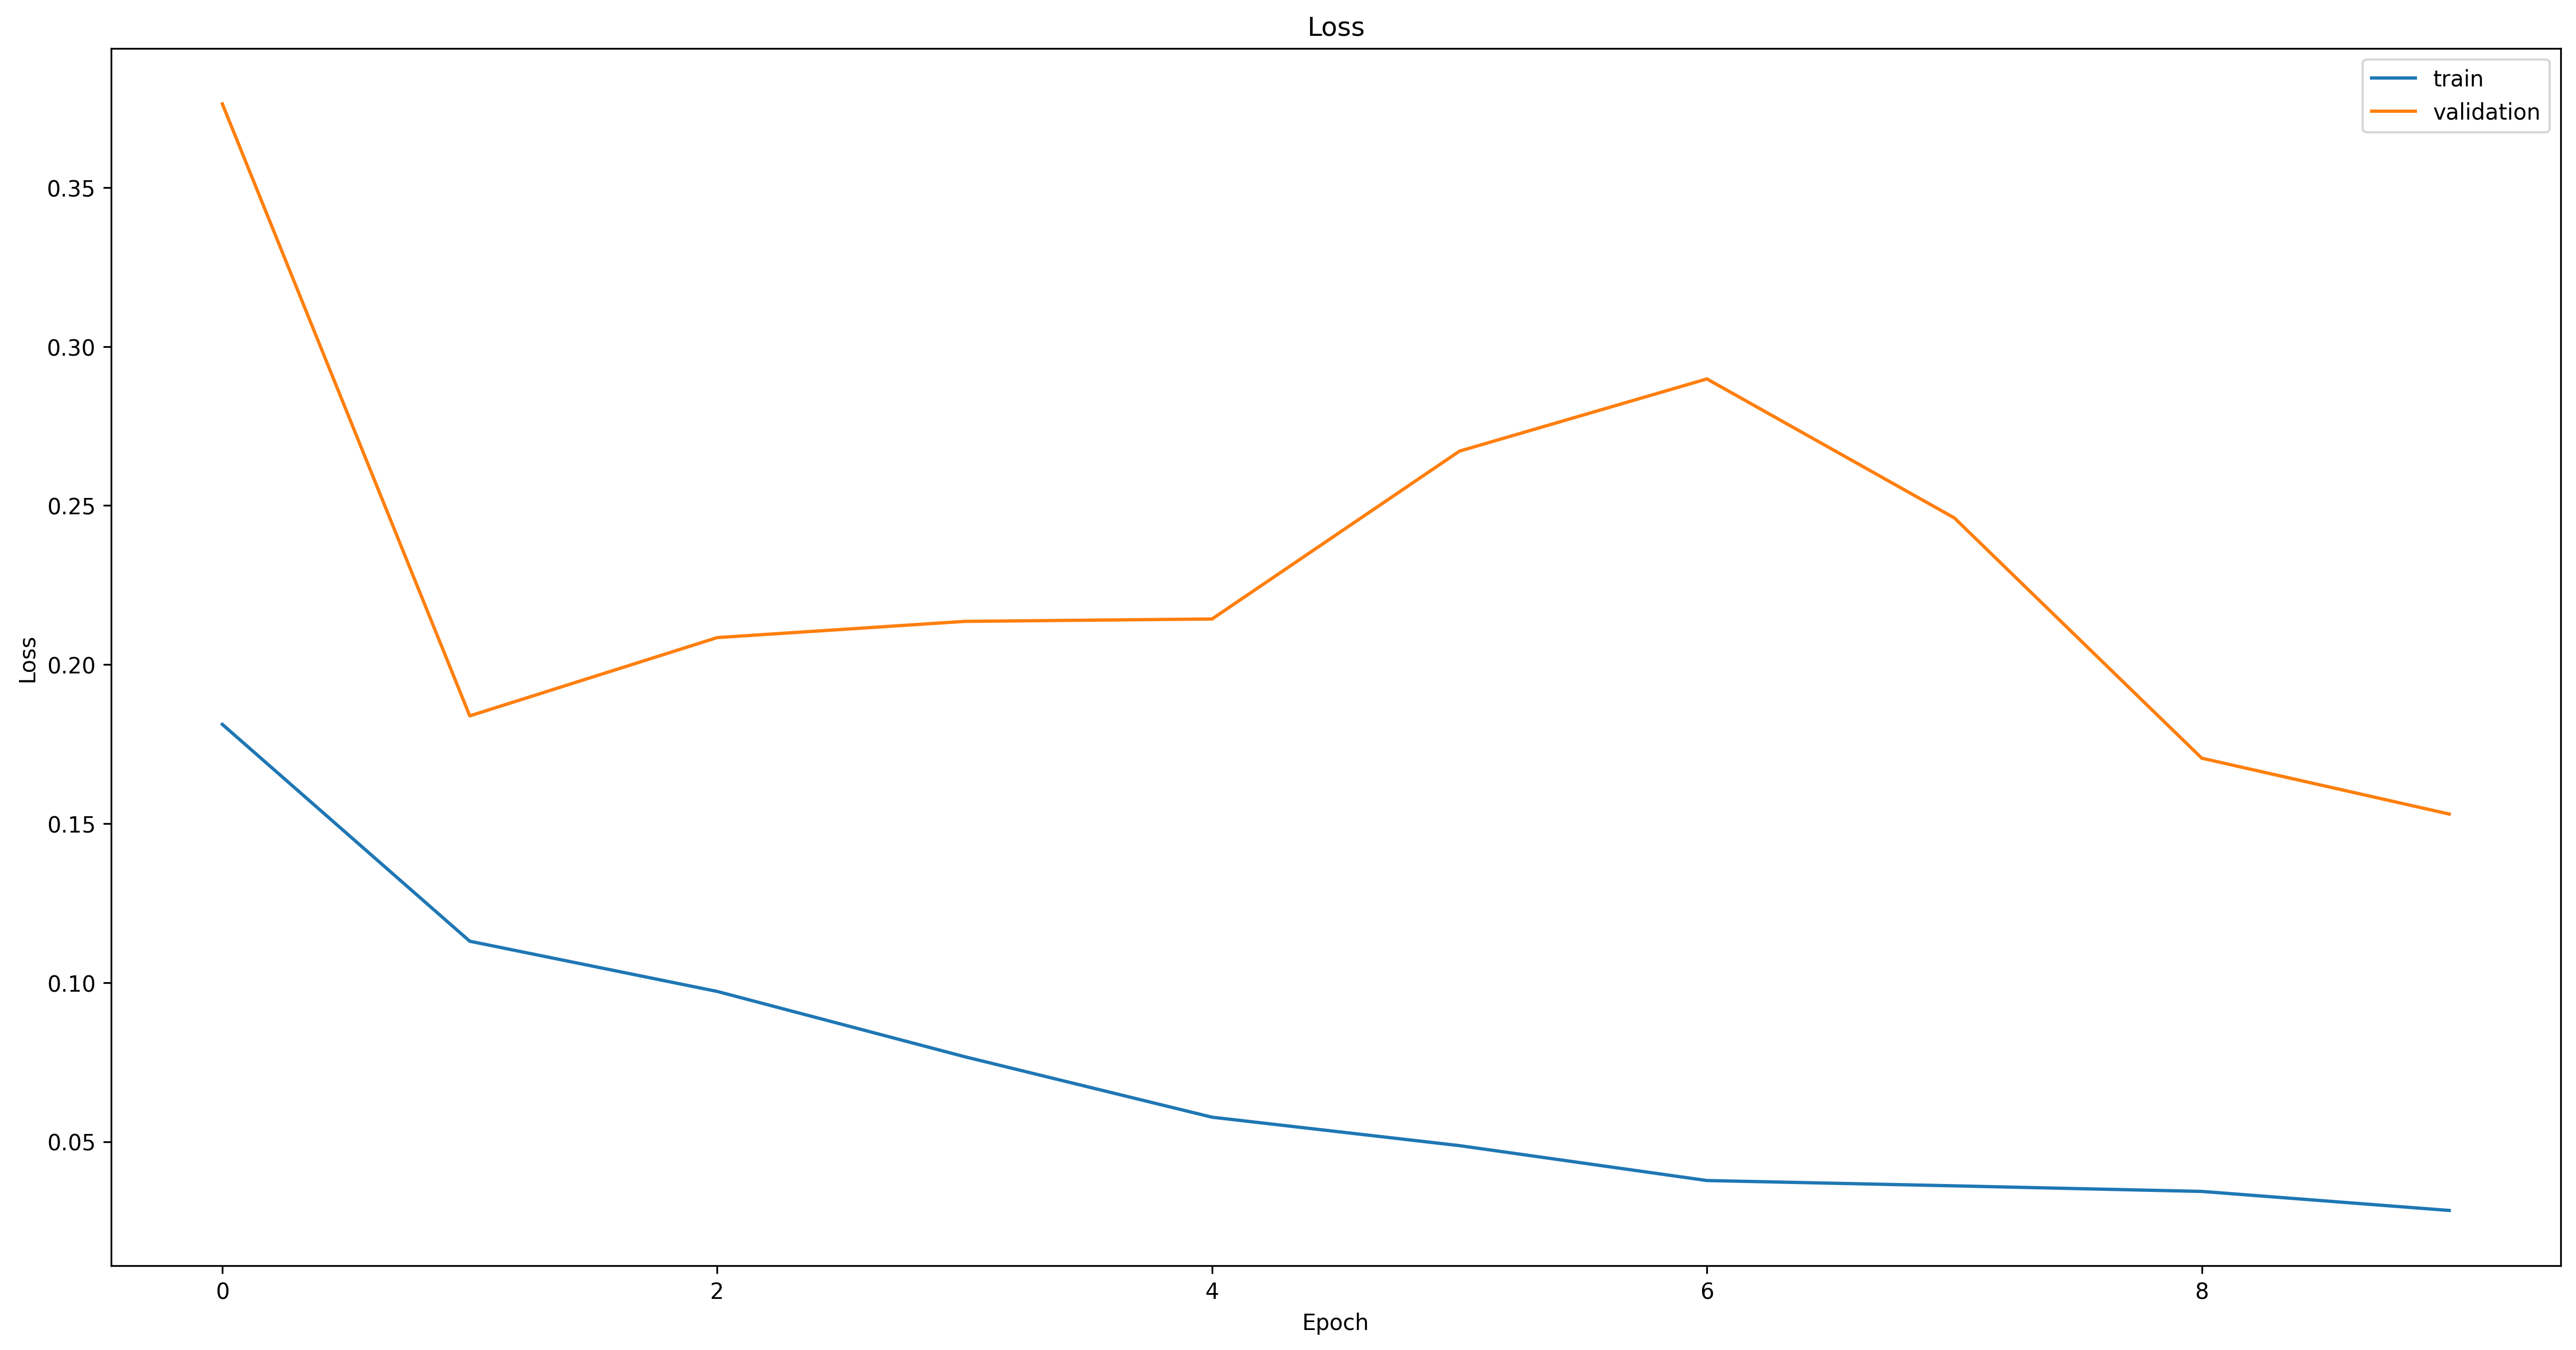

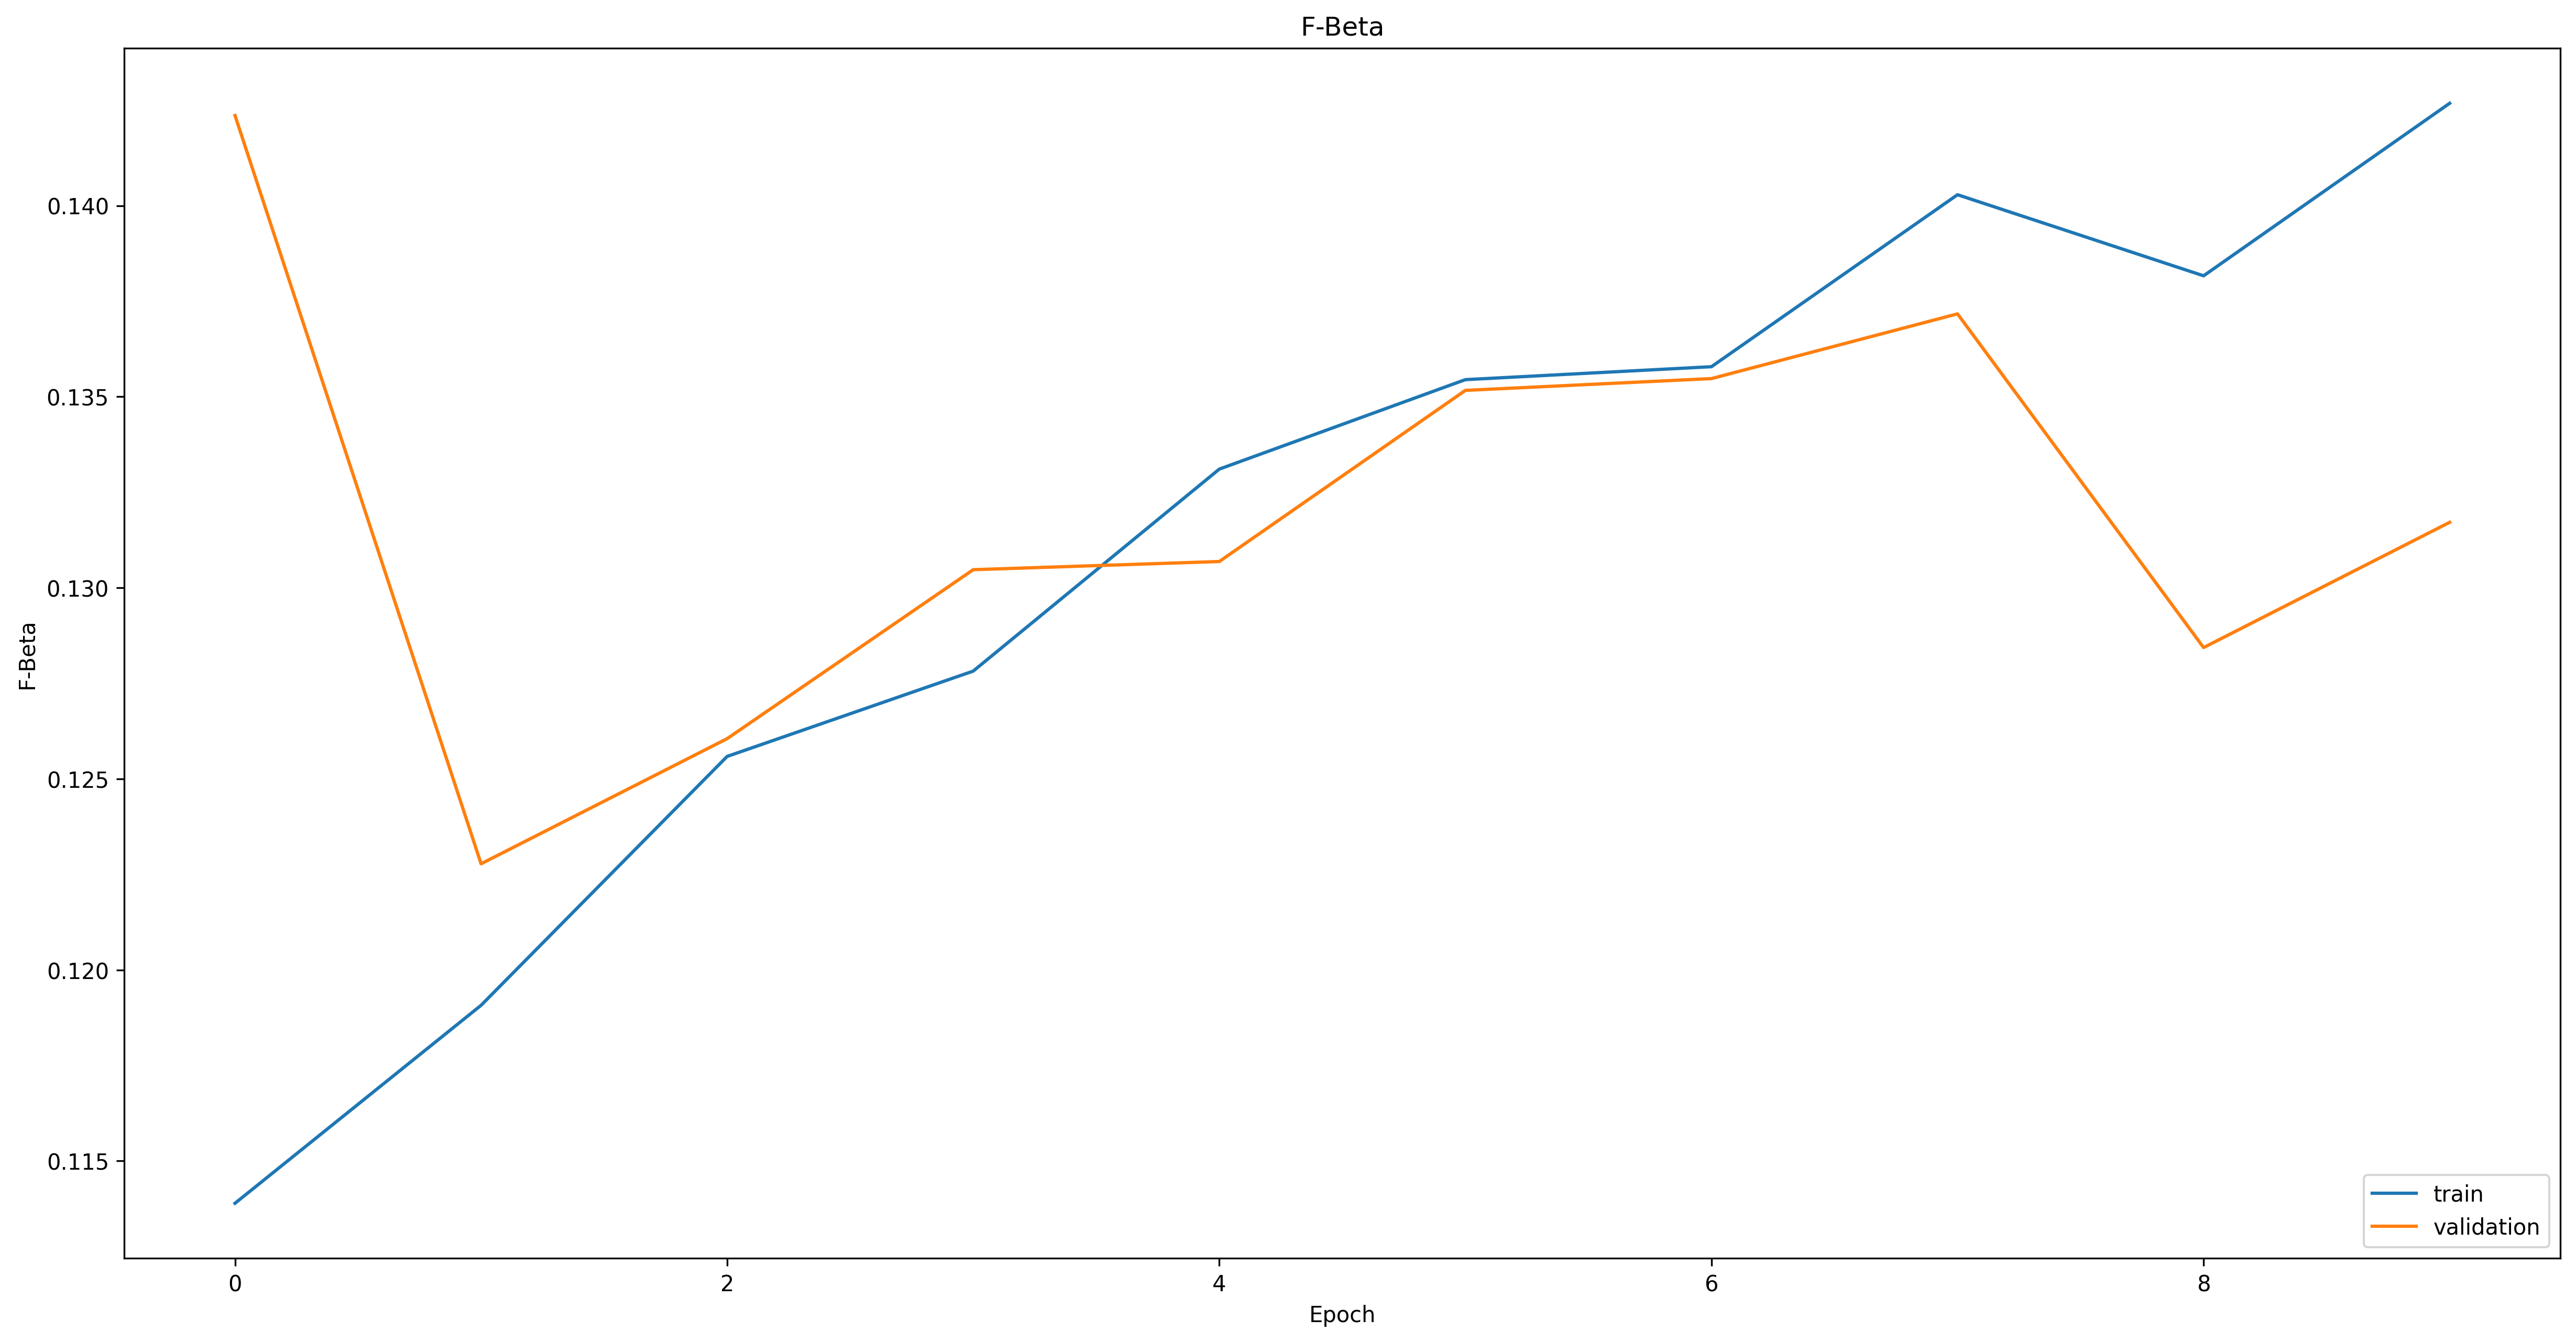

In [ ]:
#plot the metrics
#plot the loss
plt.figure(figsize=(20, 10), dpi=300)
losses = [loss.item() for loss in metric_dict['train']['loss']]
losses_validation = [loss.item() for loss in metric_dict['validation']['loss']]
plt.plot(losses, label='train')
plt.plot(losses_validation, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

#plot f beta
plt.figure(figsize=(20, 10), dpi=300)
plt.plot(metric_dict['train']['f_beta'], label='train')
plt.plot(metric_dict['validation']['f_beta'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('F-Beta')
plt.title('F-Beta')
plt.legend()
plt.show()

#plot precision
plt.figure(figsize=(20, 10), dpi=300)
plt.plot(metric_dict['train']['precision'], label='train')
plt.plot(metric_dict['validation']['precision'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.show()

In [ ]:
#save the model
save_path = 'test/' + date + '_model.pt'
#create the directory if it does not exist
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))
#save the model
torch.save(model.state_dict(), save_path)

In [ ]:
#load the model
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
#do evaluation
test_dataaset = DfDataset(df=X_test, data_path_col='path_to_img', label_cols=label_names, transform=normalization_transform)
test_dataloader = DataLoader(test_dataaset, batch_size=32, shuffle=False)
model.eval()
predictions = []
labels_list = []
for data, labels in test_dataloader:
    data = data.to(device)
    labels = labels.to(device)
    labels_list.append(labels.cpu().detach())
    outputs = model(data)
    #outputs = torch.sigmoid(outputs) > 0.5
    predictions.append(outputs.cpu().detach())
all_predictions = torch.cat(predictions)
all_labels = torch.cat(labels_list)


In [ ]:
#save predictions and labels
save_path = 'test/' + 'predictions.pt'
torch.save(all_predictions, save_path)
save_path = 'test/' + 'labels.pt'
torch.save(all_labels, save_path)


In [ ]:
#load predictions and labels
load_path_predictions = 'test/' + 'predictions.pt'
load_path_labels = 'test/' + 'labels.pt'
all_predictions = torch.load(load_path_predictions)
all_labels = torch.load(load_path_labels)

In [ ]:
#calculate metrics
recal = multi_label_recal(all_labels, all_predictions, average='macro')
precision = multi_label_precision(all_labels, all_predictions, average='macro')
f_beta = multi_label_f_beta(all_labels, all_predictions, beta=1, average='macro')
accuracy = multi_label_accuracy(all_labels, all_predictions, average='macro')
print(f'recall: {recal}', f'precision: {precision}', f'f_beta: {f_beta}', f'accuracy: {accuracy}')


recall: 0.5608075392899776 precision: 0.700334913459356 f_beta: 0.5890082656395031 accuracy: 0.9578651685393257


c:\Users\elyes\IRD-DeepLearning\pattern\metrics\multi_label_metrics.py:107: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\pattern\metrics\multi_label_metrics.py:107: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\pattern\metrics\multi_label_metrics.py:133: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)


In [ ]:
from sklearn.metrics import  multilabel_confusion_matrix, ConfusionMatrixDisplay
#calculate confusion matrix
all_predictions_processed = torch.sigmoid(all_predictions) > 0.5
confusion_matrix = multilabel_confusion_matrix(all_labels, all_predictions_processed)

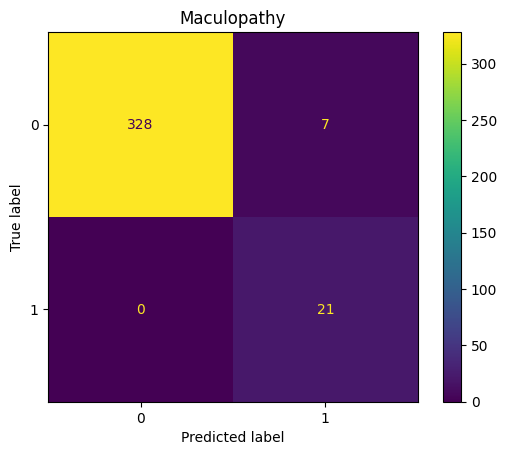

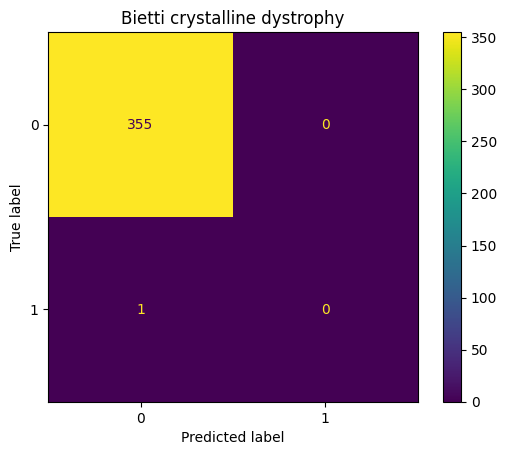

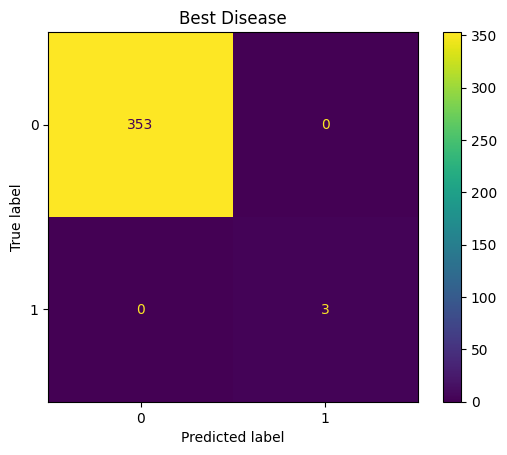

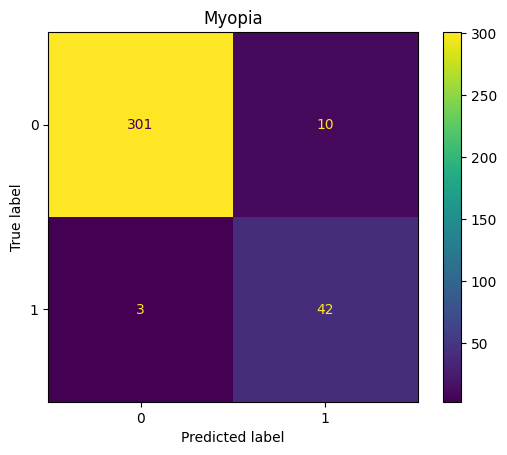

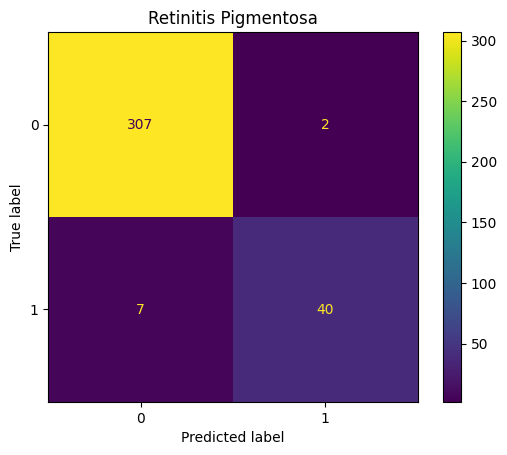

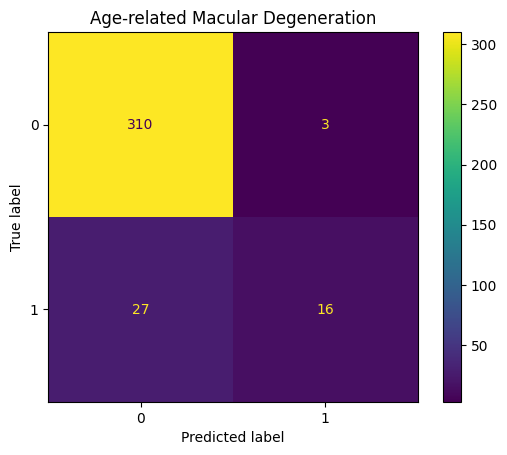

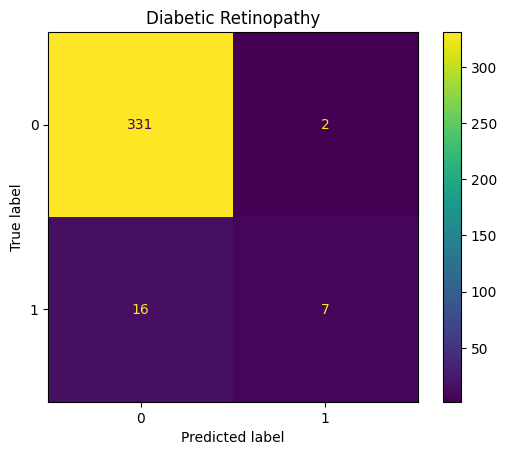

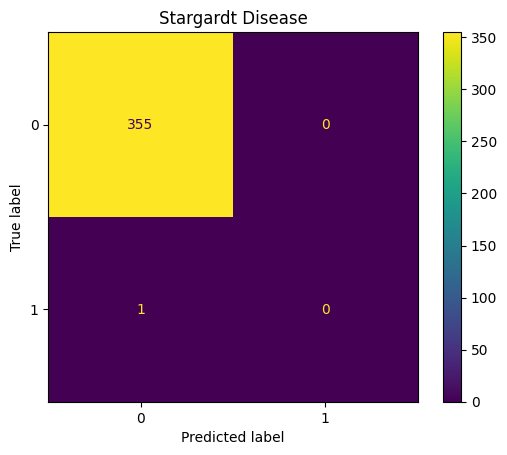

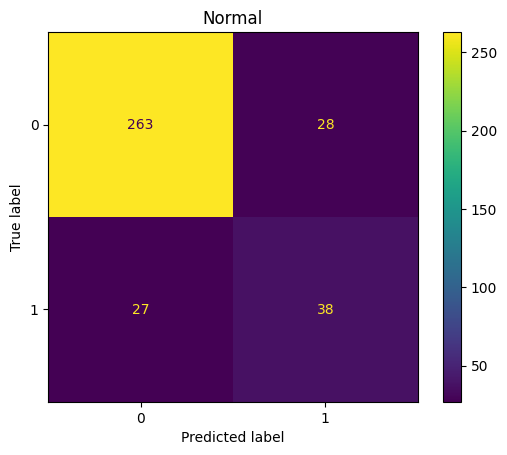

In [ ]:
#plot all the confusion matrices
for cm, label in zip(confusion_matrix, label_names):
    confusion_matrix_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    confusion_matrix_display.plot()
    plt.title(label)
    plt.show()